# Electricity Price Forecasting with Deep Neural Networks

In [1]:
#importing the Libery
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
import xgboost as xgb
import os
import warnings
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from math import sqrt

XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ['dlopen(/Users/vikky/opt/anaconda3/lib/python3.9/site-packages/xgboost/lib/libxgboost.dylib, 6): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib\n  Referenced from: /Users/vikky/opt/anaconda3/lib/python3.9/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: image not found']


# <a id='ref2'>1. Exploration and Cleaning</a>
In this dataset, we have two .csv files which contain hourly information about the electricity generation and weather in Spain for the period 2015-2019 (4 years). In particular:

> **`'weather_features.csv':`** Contains hourly information about the weather conditions (e.g. temperature, wind speed, humidity, rainfall, qualitative desctiption) of 5 major cities in Spain (Madrid, Barcelona, Valencia, Seville and Bilbao).

> **`'energy_dataset.csv':`** Contains hourly information about the generation of energy in Spain. In particular, there is info (in MW) about the amount of electricty generated by the various energy sources (fossil gas, fossil hard coal and wind energy dominate the energy grid), as well as about the total load (energy demand) of the national grid and the price of energy (&euro;/MWh). 
_Note: Since the generation of each energy type is in MW and the time-series contains hourly info, the value of each cell represents MWh (Megawatt hours)._

The information that we have about the weather of 5 major cities in Spain (highlighted by a red star on the map below) is probably more than enough for our analysis, since their geographic distribution covers most of the part of Spain's territory in a uniform manner. Moreover, it is useful to note that these 5 cities alone comprise approximately 1/3rd of the total population of Spain.

![Highlighted cities for which we have weather information](https://i.imgur.com/Hfb9vmq.png)

In [3]:
# Read the datasets
#import first dataset
df_weather = pd.read_csv('weather_features.csv', parse_dates=['dt_iso'])
#import second dataset
df_energy = pd.read_csv('energy_dataset.csv', parse_dates=['time'])

# <a id='ref3'>1.1. Energy dataset</a> 

In [4]:
#check first five rows of the dataset
df_energy.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


We will drop all the columns that are constituted by zeroes and NaNs, as they are unusable. We will also remove the columns which will not be used at all in our analysis and which contain day-ahead forecasts for the total load, the solar energy and the wind energy.

In [5]:
# Drop unusable columns

df_energy = df_energy.drop(['generation fossil coal-derived gas','generation fossil oil shale', 
                            'generation fossil peat', 'generation geothermal', 
                            'generation hydro pumped storage aggregated', 'generation marine', 
                            'generation wind offshore', 'forecast wind offshore eday ahead',
                            'total load forecast', 'forecast solar day ahead',
                            'forecast wind onshore day ahead'], 
                            axis=1)

In [6]:
#check mathmatic realition of the dataset
df_energy.describe().round(2)

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,price actual
count,35045.00,35046.00,35046.00,35046.00,35045.00,35045.00,35045.00,35046.00,35047.00,35046.00,35046.00,35046.00,35045.00,35046.00,35028.00,35064.00,35064.00
mean,383.51,448.06,5622.74,4256.07,298.32,475.58,972.12,2605.11,6263.91,60.23,85.64,1432.67,269.45,5464.48,28696.94,49.87,57.88
std,85.35,354.57,2201.83,1961.60,52.52,792.41,400.78,1835.20,839.67,20.24,14.08,1680.12,50.20,3213.69,4574.99,14.62,14.20
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18041.00,2.06,9.33
25%,333.00,0.00,4126.00,2527.00,263.00,0.00,637.00,1077.25,5760.00,53.00,73.00,71.00,240.00,2933.00,24807.75,41.49,49.35
50%,367.00,509.00,4969.00,4474.00,300.00,68.00,906.00,2164.00,6566.00,57.00,88.00,616.00,279.00,4849.00,28901.00,50.52,58.02
75%,433.00,757.00,6429.00,5838.75,330.00,616.00,1250.00,3757.00,7025.00,80.00,97.00,2578.00,310.00,7398.00,32192.00,60.53,68.01
max,592.00,999.00,20034.00,8359.00,449.00,4523.00,2000.00,9728.00,7117.00,106.00,119.00,5792.00,357.00,17436.00,41015.00,101.99,116.80


In [7]:
#check infomation of the dataset
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 18 columns):
time                                           35064 non-null object
generation biomass                             35045 non-null float64
generation fossil brown coal/lignite           35046 non-null float64
generation fossil gas                          35046 non-null float64
generation fossil hard coal                    35046 non-null float64
generation fossil oil                          35045 non-null float64
generation hydro pumped storage consumption    35045 non-null float64
generation hydro run-of-river and poundage     35045 non-null float64
generation hydro water reservoir               35046 non-null float64
generation nuclear                             35047 non-null float64
generation other                               35046 non-null float64
generation other renewable                     35046 non-null float64
generation solar                               35046

The 'time' column, which we also want to function as the index of the observations in a time-series, has not been parsed correctly and is recognized as an object.

In [8]:
# Convert time to datetime object and set it as index
df_energy['time'] = pd.to_datetime(df_energy['time'], utc=True, infer_datetime_format=True)
df_energy = df_energy.set_index('time')

In [9]:
# Find NaNs and duplicates in df_energy

print('There are {} missing values or NaNs in df_energy.'
      .format(df_energy.isnull().values.sum()))

temp_energy = df_energy.duplicated(keep='first').sum()

print('There are {} duplicate rows in df_energy based on all columns.'
      .format(temp_energy))

There are 292 missing values or NaNs in df_energy.
There are 0 duplicate rows in df_energy based on all columns.


As we can see, `df_energy` has no duplicate values. Nevertheless, it has some NaNs and thus, we have to investigate further. Since this is a time-series forecasting task, we cannot simply drop the rows with the missing values and it would be a better idea to fill the missing values using interpolation.

In [10]:
# Find the number of NaNs in each column

df_energy.isnull().sum(axis=0)

generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
total load actual                              36
price day ahead                                 0
price actual                                    0
dtype: int64

Most null values can be found in the 'total load actual' column. Therefore, it is a good idea to visualize it and see what we can do. The good news is that there are no NaNs in the 'price actual' column, which we will use as the target variable in order to train our model. The similar numbers in null values in the columns which have to do with the type of energy generation *probably indicate that they will also appear in the same rows*. Let us first define a plot function which we will then use so as to visualize the 'total load actual' column, as well as other columns.

In [11]:
# Define a function to plot different types of time-series

def plot_series(df=None, column=None, series=pd.Series([]), 
                label=None, ylabel=None, title=None, start=0, end=None):
    """
    Plots a certain time-series which has either been loaded in a dataframe
    and which constitutes one of its columns or it a custom pandas series 
    created by the user. The user can define either the 'df' and the 'column' 
    or the 'series' and additionally, can also define the 'label', the 
    'ylabel', the 'title', the 'start' and the 'end' of the plot.
    """
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

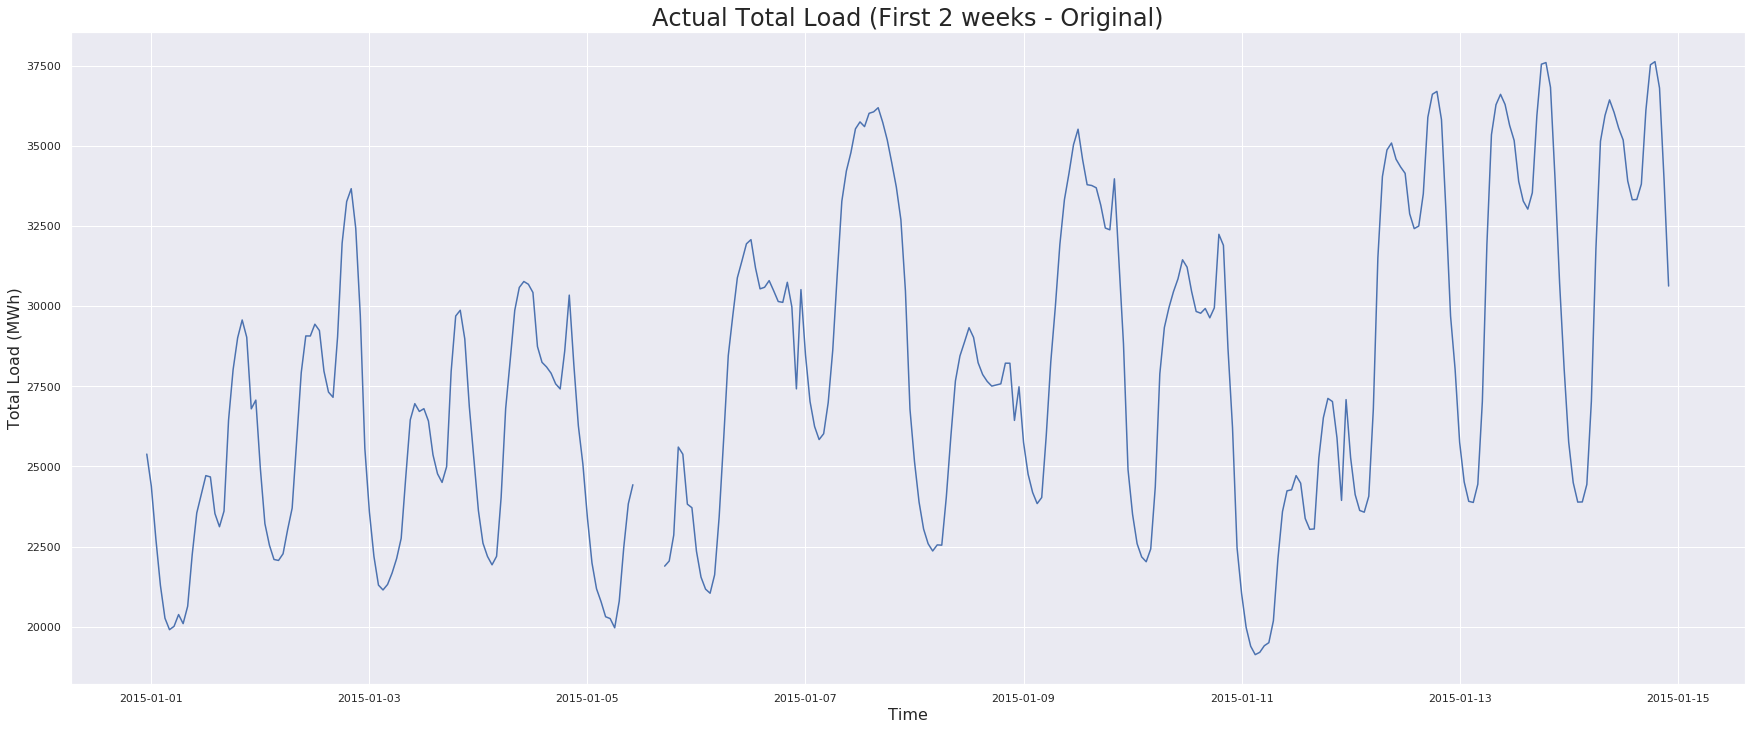

In [12]:
# Zoom into the plot of the hourly (actual) total load

ax = plot_series(df=df_energy, column='total load actual', ylabel='Total Load (MWh)',
                 title='Actual Total Load (First 2 weeks - Original)', end=24*7*2)
plt.show()

After zooming into the first 2 weeks of the 'total load actual' column, we can already see that there are null values for a few hours. However, the number of the missing values and the behavior of the series indicate that an interpolation would fill the NaNs quite well. Let us further investigate if the null values coincide across the different columns. Let us display the last five rows.

In [13]:
# Display the rows with null values

df_energy[df_energy.isnull().any(axis=1)].tail()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,price actual
time,,,,,,,,,,,,,,,,,
2016-11-23 03:00:00+00:00,NaN,900.0,4838.0,4547.0,269.0,1413.0,795.0,435.0,5040.0,60.0,85.0,15.0,227.0,4598.0,23112.0,43.19,49.11
2017-11-14 11:00:00+00:00,0.0,0.0,10064.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,60.53,66.17
2017-11-14 18:00:00+00:00,0.0,0.0,12336.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,68.05,75.45
2018-06-11 16:00:00+00:00,331.0,506.0,7538.0,5360.0,300.0,1.0,1134.0,4258.0,5856.0,52.0,96.0,170.0,269.0,9165.0,NaN,69.87,64.93
2018-07-11 07:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.01,69.79


If we manually searched through all of them, we would confirm that the null values in the columns which have to do with the type of energy generation mostly coincide. The null values in 'actual total load' also coincide with the aforementioned columns, but also appear in other rows as well. In order to handle the null values in `df_energy`, we will use a linear interpolation with a forward direction. Perhaps other kinds of interpolation would be better; nevertheless, we prefer to use the simplest model possible. Only a small part of our input data will be noisy and it will not affect performance noticeably.

In [14]:
# Fill null values using interpolation

df_energy.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

In [15]:
# Display the number of non-zero values in each column

print('Non-zero values in each column:\n', df_energy.astype(bool).sum(axis=0), sep='\n')

Non-zero values in each column:

generation biomass                             35060
generation fossil brown coal/lignite           24540
generation fossil gas                          35063
generation fossil hard coal                    35061
generation fossil oil                          35061
generation hydro pumped storage consumption    22450
generation hydro run-of-river and poundage     35061
generation hydro water reservoir               35061
generation nuclear                             35061
generation other                               35060
generation other renewable                     35061
generation solar                               35061
generation waste                               35061
generation wind onshore                        35061
total load actual                              35064
price day ahead                                35064
price actual                                   35064
dtype: int64


It look like `df_energy` has been cleaned successfully and is ready for further use as input into our model. The 1-4 zeroes in the columns which have to do with energy generation by type should not concern us very much. The 'generation hydro pumped storage consumption' may look suspicious, but we should have in mind that this type of energy is only used for load balancing, being consumed when in peak energy demands.

## <a id='ref4'>1.2. Weather features dataset</a> 

In [16]:
#check first five rows of the dataset
df_weather.head()

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [17]:
#check weather dataset
df_weather.describe().round(2)

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
count,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00
mean,289.62,288.33,291.09,1069.26,68.42,2.47,166.59,0.08,0.00,0.00,25.07,759.83
std,8.03,7.96,8.61,5969.63,21.90,2.10,116.61,0.40,0.01,0.22,30.77,108.73
min,262.24,262.24,262.24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,200.00
25%,283.67,282.48,284.65,1013.00,53.00,1.00,55.00,0.00,0.00,0.00,0.00,800.00
50%,289.15,288.15,290.15,1018.00,72.00,2.00,177.00,0.00,0.00,0.00,20.00,800.00
75%,295.15,293.73,297.15,1022.00,87.00,4.00,270.00,0.00,0.00,0.00,40.00,801.00
max,315.60,315.15,321.15,1008371.00,100.00,133.00,360.00,12.00,2.32,21.50,100.00,804.00


Here, we can see that all columns of `df_weather` have the same number of rows; we still have to check what is the case for each city individually, though. We should note that the temperatures are in Kelvin. The most important thing to notice is that there are some **problems** and **outliers**. In particular:
- There is at least one outlier in the 'pressure' column as the maximum value is 1,008,371 hPa or approximately 100 MPa, which is roughly the pressure at the bottom of Mariana Trench about 11 km below ocean surface [[2]](#ref5). This cannot be the case here.
- There is at least one outlier in the 'wind_speed' column as the maximum value is 133 m/s. This measurement is close to the fastest wind speed ever recorded on Earth, caused by the 1999 Bridge Creek–Moore tornado [[3]](#ref6), a F5 (the largest intensity of the Fujita scale) tornado [[4]](#ref7). A tornado of such intensity has not been recorded in Spain [[5]](#ref9) and hopefully will not happen in the future as well. 
- The 'rain_3h' column is supposed to provide information about the precipitation (i.e. rain) of the last 3 hours in mm. Since the 'rain_1h' column is supposed to provide the same information but about just the last hour, it would be logical to assume that its mean would be less than that of 'rain_3h'. However, this is not the case in the statistical description above. So, it would be a good idea to further examine those columns.

In [18]:
# Print the type of each variable in df_weather

df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
dt_iso                 178396 non-null object
city_name              178396 non-null object
temp                   178396 non-null float64
temp_min               178396 non-null float64
temp_max               178396 non-null float64
pressure               178396 non-null int64
humidity               178396 non-null int64
wind_speed             178396 non-null int64
wind_deg               178396 non-null int64
rain_1h                178396 non-null float64
rain_3h                178396 non-null float64
snow_3h                178396 non-null float64
clouds_all             178396 non-null int64
weather_id             178396 non-null int64
weather_main           178396 non-null object
weather_description    178396 non-null object
weather_icon           178396 non-null object
dtypes: float64(6), int64(6), object(5)
memory usage: 23.1+ MB


We have to change the type of some of the columns, so that all of them are float64. We also have to parse 'dt_iso' correctly and actually rename it as 'time' so that it matches with the index of `df_energy`.

In [19]:
def df_convert_dtypes(df, convert_from, convert_to):
    cols = df.select_dtypes(include=[convert_from]).columns
    for col in cols:
        df[col] = df[col].values.astype(convert_to)
    return df

In [20]:
# Convert columns with int64 type values to float64 type

df_weather = df_convert_dtypes(df_weather, np.int64, np.float64)

In [21]:
# Convert dt_iso to datetime type, rename it and set it as index

df_weather['time'] = pd.to_datetime(df_weather['dt_iso'], utc=True, infer_datetime_format=True)
df_weather = df_weather.drop(['dt_iso'], axis=1)
df_weather = df_weather.set_index('time')

We have to **split** the `df_weather` dataset into 5 datasets, **one for each different city** (Madrid, Barcelona, Bilbao, Seville and Valencia). But first, let's see the average values for each column, grouped by each city (note that the 'weather_id' average has no meaning whatsoever).

In [22]:
# Display average weather features grouped by each city

mean_weather_by_city = df_weather.groupby('city_name').mean()
mean_weather_by_city

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
city_name,,,,,,,,,,,,
Barcelona,289.848248,288.594704,291.021987,1284.010486,73.994221,2.786588,187.188043,0.117079,0.000327,0.000000,23.229648,760.917465
Bilbao,286.378489,284.916661,288.036687,1017.567439,79.089455,1.957470,159.883536,0.123493,0.001034,0.023455,43.960697,723.943228
Madrid,288.061071,286.824877,289.155600,1011.838448,59.776932,2.441696,173.293159,0.055083,0.000129,0.000029,22.397028,762.260264
Seville,293.105431,291.184103,295.962431,1018.504711,64.140732,2.483787,151.757179,0.045392,0.000180,0.000000,14.748770,771.409849
Valencia,290.780780,290.222277,291.355025,1015.973794,65.145113,2.692815,160.753820,0.035924,0.000226,0.000154,20.820999,781.228283


In [23]:
# Find NaNs and duplicates in df_weather

print('There are {} missing values or NaNs in df_weather.'
      .format(df_weather.isnull().values.sum()))

temp_weather = df_weather.duplicated(keep='first').sum()

print('There are {} duplicate rows in df_weather based on all columns.'
      .format(temp_weather))

There are 0 missing values or NaNs in df_weather.
There are 8622 duplicate rows in df_weather based on all columns.


It seems that `df_weather` has a lot of *duplicate values*. However, **the method above may also show us rows which have the exame same values**. This is not what we are looking for. What we want to ensure, is that **there are no duplicate index rows**, i.e. that we do not have multiple rows **for the exact same hour**. Of course, we also have to make sure that these duplicates concern **each individual city**. Since, `df_weather` contains information about 5 different cities, it is very useful to display the number of observations for each one and compare it with the size of `df_energy`.

In [24]:
# Display the number of rows in each dataframe

print('There are {} observations in df_energy.'.format(df_energy.shape[0]))

cities = df_weather['city_name'].unique()
grouped_weather = df_weather.groupby('city_name')

for city in cities:
    print('There are {} observations in df_weather'
          .format(grouped_weather.get_group('{}'.format(city)).shape[0]), 
          'about city: {}.'.format(city))

There are 35064 observations in df_energy.
There are 35145 observations in df_weather about city: Valencia.
There are 36267 observations in df_weather about city: Madrid.
There are 35951 observations in df_weather about city: Bilbao.
There are 35476 observations in df_weather about city:  Barcelona.
There are 35557 observations in df_weather about city: Seville.


As we can see, the two dataframes (`df_energy` and `df_weather`) cannot be merged yet. There are many duplicates for every city in `df_weather` and we should drop them and see if their number of rows match. We do this by resetting the index, keeping only the **first rows** which have the same 'time' and 'city_name' values and then setting again 'time' as the index. For further research on the dataset, let us also create a second dataframe, `df_weather_2` in which we do the same procedure, but keep only the **last rows** which have the same 'time' and 'city_name'.

In [25]:
# Create df_weather_2 and drop duplicate rows in df_weather

df_weather_2 = df_weather.reset_index().drop_duplicates(subset=['time', 'city_name'], 
                                                        keep='last').set_index('time')

df_weather = df_weather.reset_index().drop_duplicates(subset=['time', 'city_name'],
                                                      keep='first').set_index('time')

In [26]:
# Display the number of rows in each dataframe again

print('There are {} observations in df_energy.'.format(df_energy.shape[0]))

grouped_weather = df_weather.groupby('city_name')

for city in cities:
    print('There are {} observations in df_weather'
          .format(grouped_weather.get_group('{}'.format(city)).shape[0]), 
          'about city: {}.'.format(city))

There are 35064 observations in df_energy.
There are 35064 observations in df_weather about city: Valencia.
There are 35064 observations in df_weather about city: Madrid.
There are 35064 observations in df_weather about city: Bilbao.
There are 35064 observations in df_weather about city:  Barcelona.
There are 35064 observations in df_weather about city: Seville.


The column 'weather_icon' is irrelevant for our analysis, so we will drop it. Furthermore, the columns 'weather_main' and 'weather_description' contain approximately the same information as the column 'weather_id'; the information concerns a qualitative description of the weather at the given hour. So, we will work with only one of them. However, in order to make a choice, we have to check the **unique values** as well as the **consistency** of each column. 

In [27]:
# Display all the unique values in the column 'weather_description'

weather_description_unique = df_weather['weather_description'].unique()
weather_description_unique

array(['sky is clear', 'few clouds', 'scattered clouds', 'broken clouds',
       'overcast clouds', 'light rain', 'moderate rain',
       'heavy intensity rain', 'mist', 'heavy intensity shower rain',
       'shower rain', 'very heavy rain', 'thunderstorm with heavy rain',
       'thunderstorm with light rain', 'proximity thunderstorm',
       'thunderstorm', 'light intensity shower rain',
       'light intensity drizzle', 'thunderstorm with rain', 'fog',
       'smoke', 'drizzle', 'heavy intensity drizzle', 'haze',
       'proximity shower rain', 'light snow', 'rain and snow',
       'light rain and snow', 'snow', 'sleet', 'rain and drizzle',
       'light intensity drizzle rain', 'light shower snow',
       'proximity moderate rain', 'ragged shower rain', 'heavy snow',
       'sand dust whirls', 'proximity drizzle', 'dust',
       'light thunderstorm', 'squalls'], dtype=object)

In [28]:
# Display all the unique values in the column 'weather_main'

weather_main_unique = df_weather['weather_main'].unique()
weather_main_unique

array(['clear', 'clouds', 'rain', 'mist', 'thunderstorm', 'drizzle',
       'fog', 'smoke', 'haze', 'snow', 'dust', 'squall'], dtype=object)

In [29]:
# Display all the unique values in the column 'weather_id'

weather_id_unique = df_weather['weather_id'].unique()
weather_id_unique

array([800., 801., 802., 803., 804., 500., 501., 502., 701., 522., 521.,
       503., 202., 200., 211., 520., 300., 201., 741., 711., 301., 302.,
       721., 600., 616., 615., 601., 611., 311., 310., 620., 531., 602.,
       731., 761., 210., 771.])

We can see that in terms of qualitative description, the 'weather_main' column seems to contain the less detailed -or "poorest"- information, while 'weather_id' and 'weather_description' have more complex information and approximately the same number of unique values.

Nevertheless, it is also useful to check the consistency of the information in each column. Since our dataset contained duplicate rows and we utilized two different methods for cleaning it, a very good way to check the consistency of the data in these three columns would be to compare the two cleaned dataframes, `df_weather` and `df_weather_2`. In order to do this, we employ the R² ("R-squared" or "coefficient of determination") metric, after encoding 'weather_description' and 'weather_main' from strings to numerical labels.

In [30]:
# Define a function which will calculate R-squared score for the same column in two dataframes

def encode_and_display_r2_score(df_1, df_2, column, categorical=False):
    dfs = [df_1, df_2]
    if categorical:
        for df in dfs:
            le = LabelEncoder()
            df[column] = le.fit_transform(df[column])
    r2 = r2_score(df_1[column], df_2[column])
    print("R-Squared score of {} is {}".format(column, r2.round(3)))

In [31]:
# Display the R-squared scores for the columns with qualitative weather descriptions in df_weather and df_weather_2

encode_and_display_r2_score(df_weather, df_weather_2, 'weather_description', categorical=True)
encode_and_display_r2_score(df_weather, df_weather_2, 'weather_main', categorical=True)
encode_and_display_r2_score(df_weather, df_weather_2, 'weather_id')

R-Squared score of weather_description is 0.973
R-Squared score of weather_main is 0.963
R-Squared score of weather_id is 0.921


It seems that we have found incosistencies in our dataset. In particular, all three of the columns which contain qualitative info for the condition of the weather seem to contain a large part of the duplicates that we found earlier in `df_weather`. From the above R-squared scores, it seems that keeping and one-hot encoding 'weather_description' or 'weather_main' is the best idea to get the most out of information in the dataset. Note that **the R² values of these two are not comparable** because we have first encoded them; in order to actually calculate the similarity between two strings, we need to employ a different metric such as the *Levenshtein distance*, i.e. the number of edits required to transform string A to string B. In this case, even this metric would not be enough in order to make 'weather_main' and 'weather_description' comparable as the former contains only single words while the latter large phrases which describe the weather.

In [32]:
# Drop columns with qualitative weather information
df_weather = df_weather.drop(['weather_main', 'weather_id', 
                              'weather_description', 'weather_icon'], axis=1)

We have to emphasize that the method we employed above in order to check the consistency of our dataset **is not 100% accurate**. This is because it compares two dataframes from which we have cleaned the duplicates in **only two ways exclusively**; keeping the first rows and keeping the last rows of the duplicates. Nevertheless, it gives good results and can be used to check the values of the other columns as well. We should not that since we removed the duplicates based on all the columns except 'time' and 'city_name', there is no point in checking the latter.

In [33]:
# Display the R-squared for all the columns in df_weather and df_weather_2

df_weather_cols = df_weather.columns.drop('city_name')

for col in df_weather_cols:
    encode_and_display_r2_score(df_weather, df_weather_2, col)

R-Squared score of temp is 1.0
R-Squared score of temp_min is 1.0
R-Squared score of temp_max is 1.0
R-Squared score of pressure is 1.0
R-Squared score of humidity is 1.0
R-Squared score of wind_speed is 1.0
R-Squared score of wind_deg is 1.0
R-Squared score of rain_1h is 1.0
R-Squared score of rain_3h is 1.0
R-Squared score of snow_3h is 1.0
R-Squared score of clouds_all is 1.0



The above confirms our intuition that 'weather_description', 'weather_main' and 'weather_id' are the sole culprits for the duplicates in `df_weather` and although we are not absolutely certain for this (for the reasons we described above), it is more than enough to reaffirm the validity and consistency of the rest of the columns in `df_weather` which contain numerical values.

In [34]:
# Display the number of duplicates in df_weather

temp_weather = df_weather.reset_index().duplicated(subset=['time', 'city_name'], 
                                                   keep='first').sum()
print('There are {} duplicate rows in df_weather ' \
      'based on all columns except "time" and "city_name".'.format(temp_weather))

There are 0 duplicate rows in df_weather based on all columns except "time" and "city_name".


Before proceeding to the next step, i.e. merging `df_energy` and `df_weather`, we also want to treat the outliers which we found earlier in 'pressure' and 'wind_speed'. We will visualize the outliers in these columns using boxplot, change their values to NaNs and then use a linear interpolation in order to replace their values.

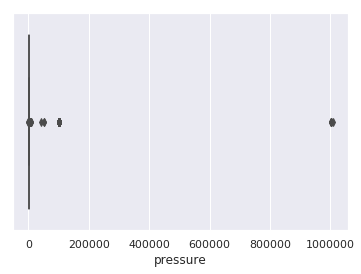

In [35]:
# Check for outliers in 'pressure' column

sns.boxplot(x=df_weather['pressure'])
plt.show()

Even a pressure of approximately 100,000 HPa or 10 MPa, which is clearly visible in the above figure, corresponds to a quantity greater than the atmospheric pressure of Venus [[2]](#ref5). In order to be sure, we will set as **NaN** every value in the 'pressure' column which is **higher than 1051 hPa**, which is just above the highest air pressure ever recorded in the Iberian peninsula [[6]](#ref9). While outliers on the low side are not visible in the boxplot above, it is a good idea to also replace the values which are **lower than 931 hPa**, i.e. the lowest air pressure ever recorded in the Iberian peninsula [[6]](#ref9).

In [36]:
# Replace outliers in 'pressure' with NaNs

df_weather.loc[df_weather.pressure > 1051, 'pressure'] = np.nan
df_weather.loc[df_weather.pressure < 931, 'pressure'] = np.nan

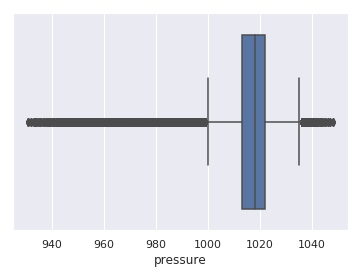

In [37]:
# Check for outliers in 'pressure' column again

sns.boxplot(x=df_weather['pressure'])
plt.show()

Things look a lot better regarding atmospheric pressure ('pressure') as the column has been cleaned of extreme-case outliers. What about 'wind_speed' however?

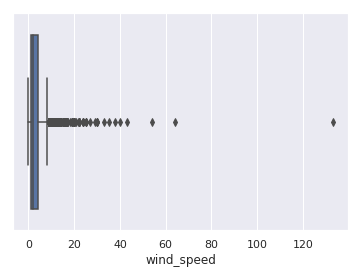

In [38]:
# Check for outliers in 'wind_speed' column

sns.boxplot(x=df_weather['wind_speed'])
plt.show()

Here, we will follow a conservative approach as above. We will set as **NaNs** the values in 'wind_speed' which are **higher than 50 m/s**, which is the highest bound (112 mph) of the wind speed estimate of a F1 (Fujita scale) tornado [[4]](#ref3), having in mind that the last F1 tornado in Spain was Gandia tornado, which was recorded on 28th September 2012 [[5]](#ref4), i.e. roughly 2 years before the starting point of our available data.

In [39]:
# Replace outliers in 'wind_speed' with NaNs

df_weather.loc[df_weather.wind_speed > 50, 'wind_speed'] = np.nan

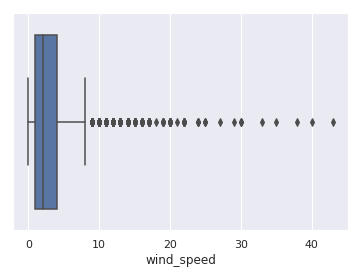

In [40]:
# Check for outliers in 'wind_speed' column again

sns.boxplot(x=df_weather['wind_speed'])
plt.show()

In [41]:
# Fill null values using interpolation

df_weather.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

Everything looks nice and clean and `df_weather` is also ready for use as input to our model. We also have to plot the 'rain_1h' and 'rain_3h' columns, as we have indicated that at least one of them (probably 'rain_3h') is quite problematic. Nevertheless, we will do so after we merge the two datasets.

## <a id='ref11'>1.3. Merging the two datasets</a> 

In [42]:
# Split the df_weather into 5 dataframes (one for each city)

df_1, df_2, df_3, df_4, df_5 = [x for _, x in df_weather.groupby('city_name')]
dfs = [df_1, df_2, df_3, df_4, df_5]

In [43]:
# Merge all dataframes into the final dataframe

df_final = df_energy

for df in dfs:
    city = df['city_name'].unique()
    city_str = str(city).replace("'", "").replace('[', '').replace(']', '').replace(' ', '')
    df = df.add_suffix('_{}'.format(city_str))
    df_final = df_final.merge(df, on=['time'], how='outer')
    df_final = df_final.drop('city_name_{}'.format(city_str), axis=1)
    
df_final.columns

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load actual',
       'price day ahead', 'price actual', 'temp_Barcelona',
       'temp_min_Barcelona', 'temp_max_Barcelona', 'pressure_Barcelona',
       'humidity_Barcelona', 'wind_speed_Barcelona', 'wind_deg_Barcelona',
       'rain_1h_Barcelona', 'rain_3h_Barcelona', 'snow_3h_Barcelona',
       'clouds_all_Barcelona', 'temp_Bilbao', 'temp_min_Bilbao',
       'temp_max_Bilbao', 'pressure_Bilbao', 'humidity_Bilbao',
       'wind_speed_Bilbao', 'wind_deg_Bilbao', 'rain_1h_Bilbao',
       'rain_3h_Bilbao', 'snow_3h_Bilbao', 'clo

In [44]:
# Display the number of NaNs and duplicates in the final dataframe

print('There are {} missing values or NaNs in df_final.'
      .format(df_final.isnull().values.sum()))

temp_final = df_final.duplicated(keep='first').sum()

print('\nThere are {} duplicate rows in df_energy based on all columns.'
      .format(temp_final))

There are 0 missing values or NaNs in df_final.

There are 0 duplicate rows in df_energy based on all columns.


# <a id='ref30'>2. Visualizations and Time Series Analysis</a>

## <a id='ref12'>2.1. Useful visualizations and insights</a> 

Before anything else, we will check the 'rain_1h' and 'rain_3h' columns for a specific city.

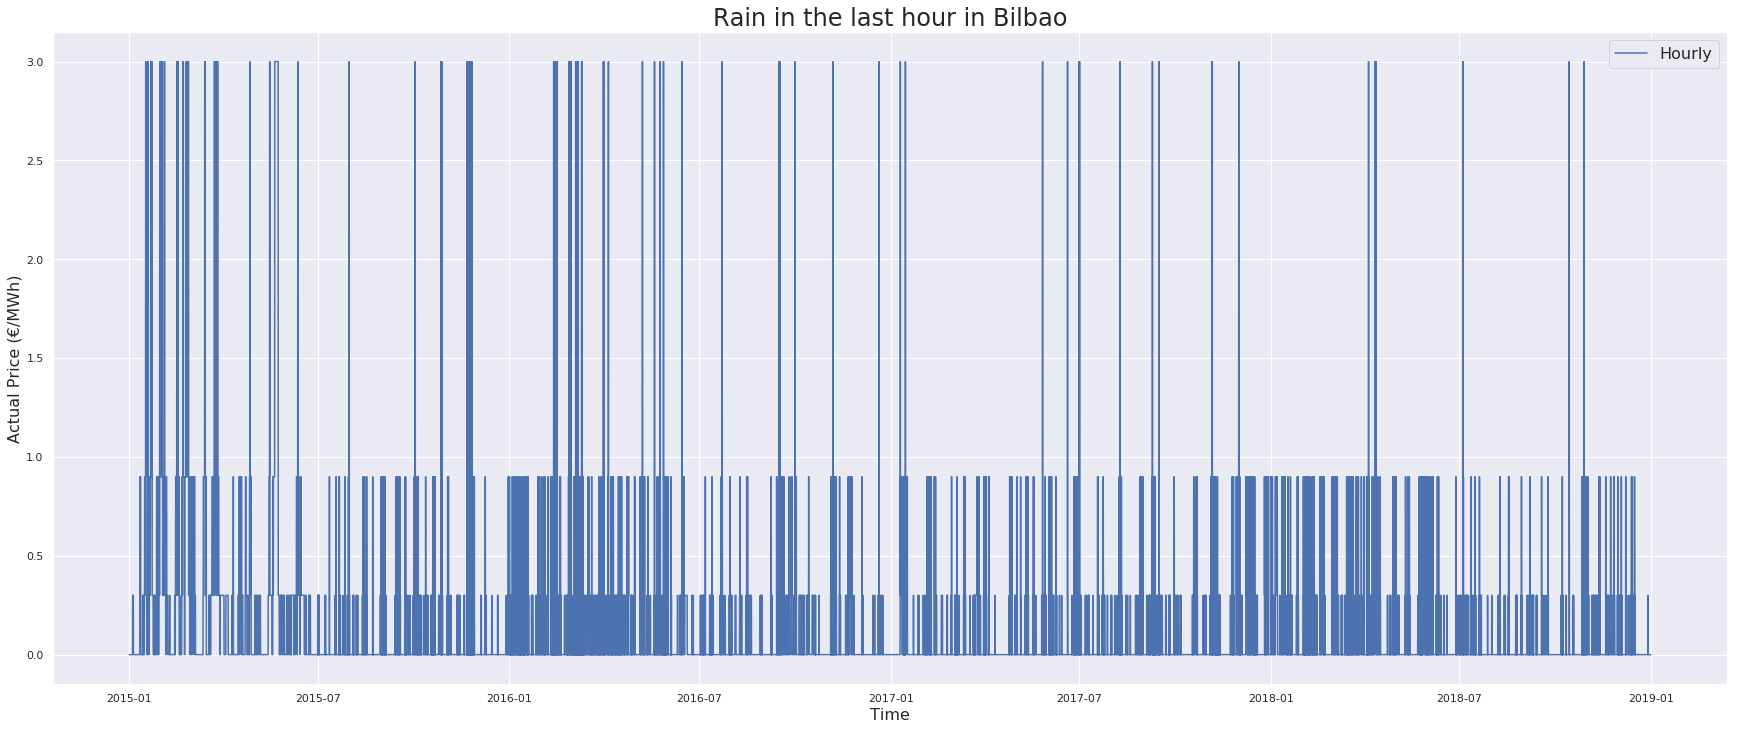

In [45]:
# Plot the 'rain_1h' for Bilbao

ax = plot_series(df_final, 'rain_1h_Bilbao', 
                 label='Hourly', ylabel='Actual Price (€/MWh)',
                 title='Rain in the last hour in Bilbao')
plt.show()

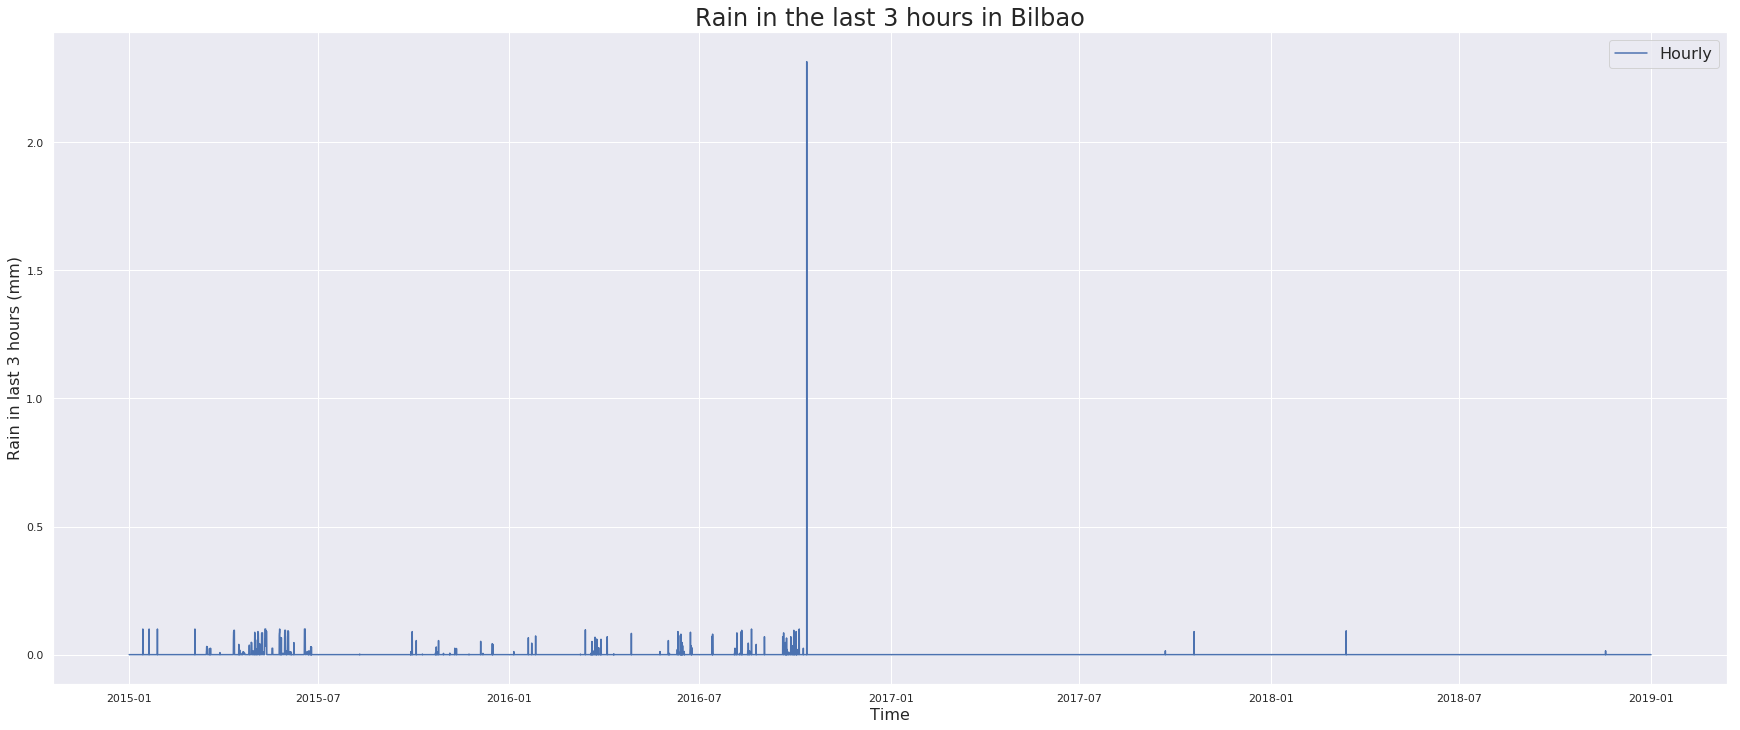

In [46]:
# Plot the 'rain_3h' for Bilbao

ax = plot_series(df_final, 'rain_3h_Bilbao', 
                 label='Hourly', ylabel='Rain in last 3 hours (mm)',
                 title='Rain in the last 3 hours in Bilbao')
plt.show()

From the two figures aboce, we can conclude that **'rain_3h' is an unreliable feature which will drop from the dataset**.

In [47]:
cities = ['Barcelona', 'Bilbao', 'Madrid', 'Seville', 'Valencia']

for city in cities:
    df_final = df_final.drop(['rain_3h_{}'.format(city)], axis=1)

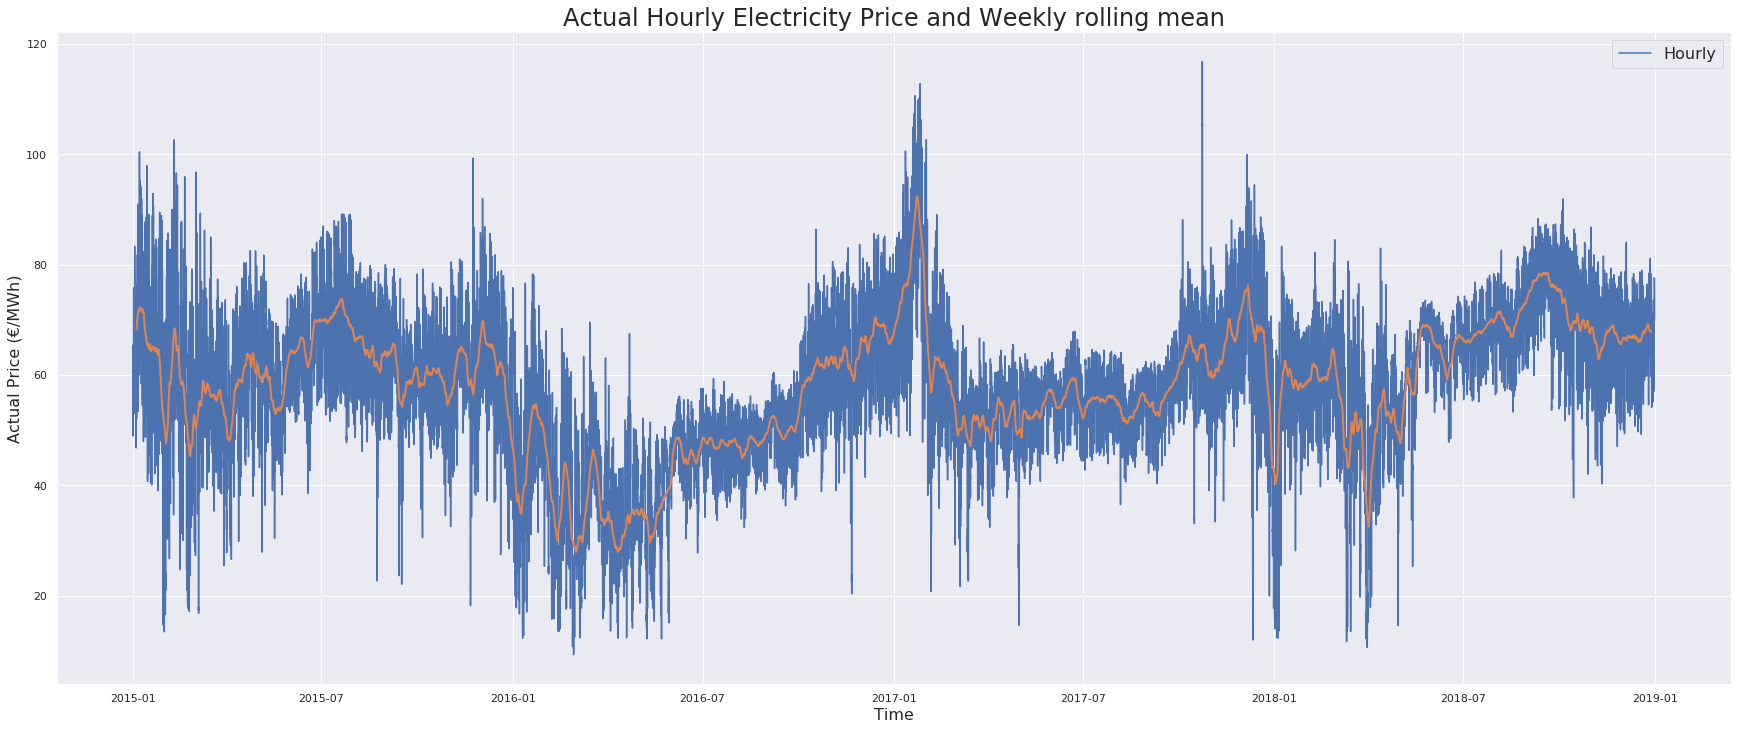

In [48]:
# Plot the hourly actual electricity price, along with the weekly rolling mean

rolling = df_final['price actual'].rolling(24*7, center=True).mean()
ax = plot_series(df_final, 'price actual', label='Hourly', ylabel='Actual Price (€/MWh)',
                 title='Actual Hourly Electricity Price and Weekly rolling mean')
ax.plot(rolling, linestyle='-', linewidth=2, label='Weekly rolling mean')
plt.show()

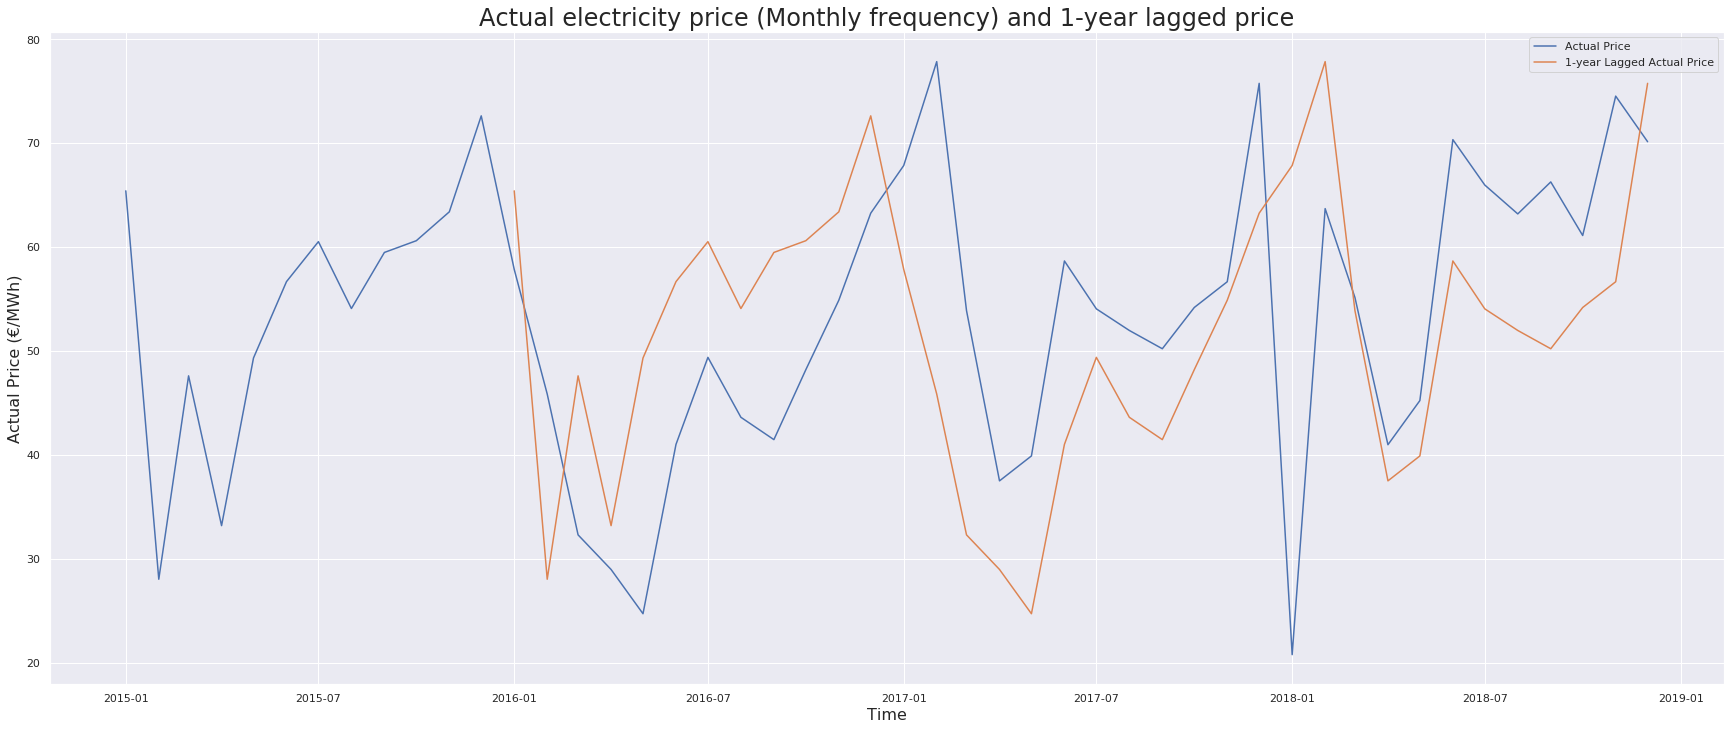

In [49]:
# Plot the electricity price (monthly frequence) along with its 1-year lagged series

monthly_price = df_final['price actual'].asfreq('M')
ax = plot_series(series=monthly_price, ylabel='Actual Price (€/MWh)',
                 title='Actual electricity price (Monthly frequency) and 1-year lagged price')
shifted = df_final['price actual'].asfreq('M').shift(12)
ax.plot(shifted, label='Hourly')
ax.legend(['Actual Price', '1-year Lagged Actual Price'])
plt.show()

The figure above shows the (resampled) monthly frequency of the actual electricity price, along with its 1-year lagged monthly frequency. From this, we can see that there are indeed **seasonal patterns at the monthly scale**, as certain "spikes" in the time-series take place in exactly the same months. This means that it would be a good idea to create a new feature for the months. If the figure displayed the 1-year lagged actual energy price at hourly or weekly time scales, we would -of course- see no such seasonal patterns.

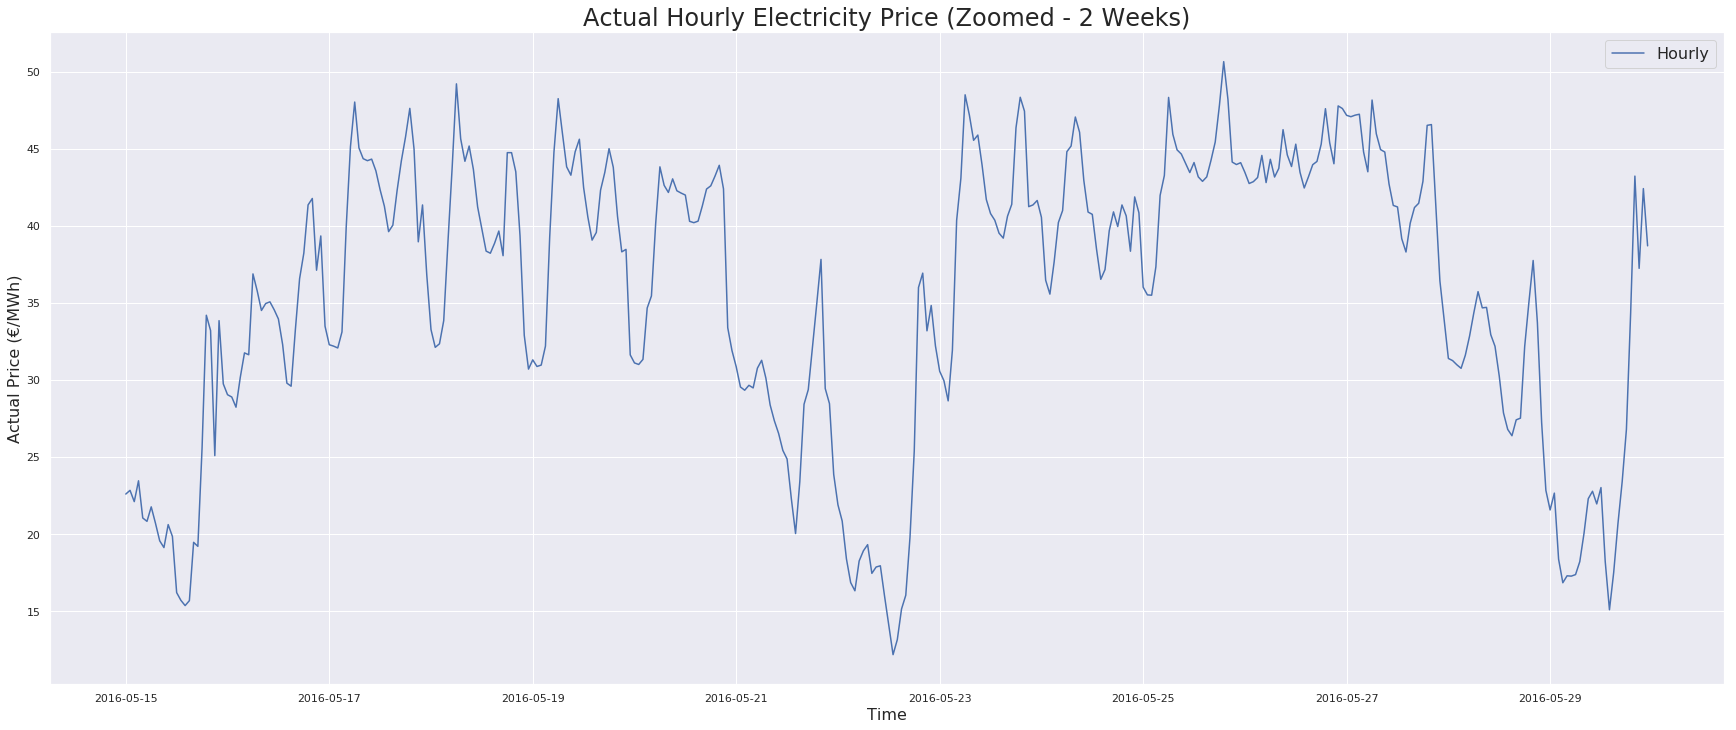

In [50]:
# Plot the actual electricity price at a daily/weekly scale

ax = plot_series(df_final, 'price actual', label='Hourly', ylabel='Actual Price (€/MWh)',
                 start=1 + 24 * 500, end=1 + 24 * 515,
                 title='Actual Hourly Electricity Price (Zoomed - 2 Weeks)')
plt.show()

In the figure above, we have plotted that actual hourly electricity price from 15/06/2016 (Sunday) at 00:00 up to 29/06/2016 (Sunday) at 23:00, i.e. two weeks of data. We can observe that there are many patterns and periodicities, such as:
- A periodicity from week to week, as the electricity price tends to be higher during business days and lower during weekends and especially during sundays.
- An intradyay periodicity, as the price is higher during the day and lower during the night.
- A periodicity within the business hours, as in some cases the electricity price drops for a few hours, which is probably due to "siesta", the traditional lunch break between 01:30PM and 04:30PM, as Spain does not strictly follow the 9AM-5PM business day.

Later on, we will make sure that we will generate features which contain these kinds of information.

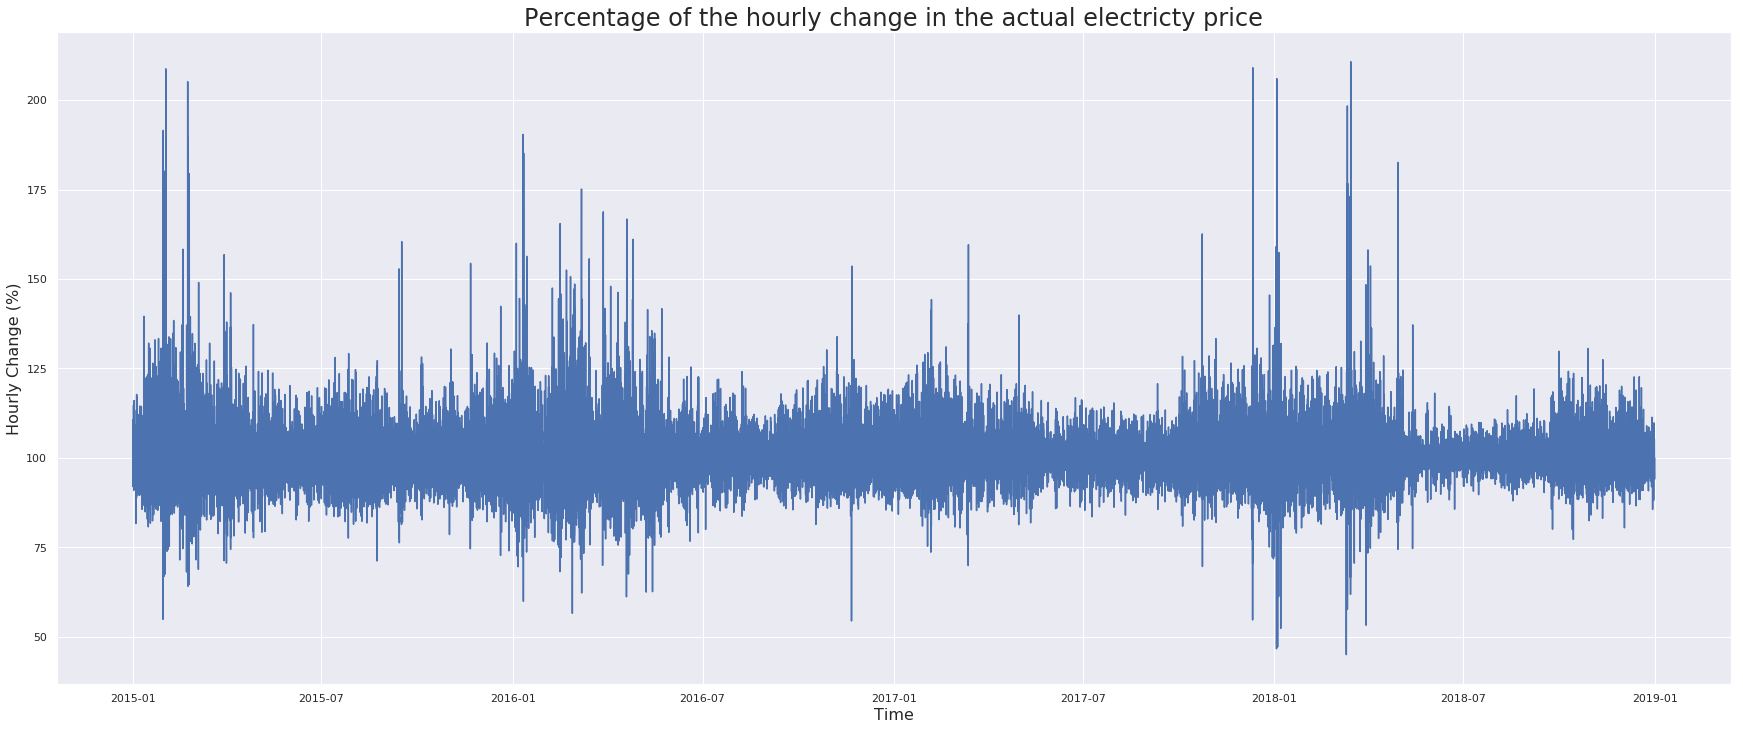

In [51]:
# Plot the percentage of the hourly change in the actual electricity price

change = df_energy['price actual'].div(df_energy['price actual'].shift(1)).mul(100)
ax = plot_series(series=change, ylabel='Hourly Change (%)', 
                 title='Percentage of the hourly change in the actual electricty price')
plt.show()

From the figure above, we can see that the change in the actual price from hour to hour is in most of the cases between -25% (actual price \* 0.75) and +25% (actual price \* 1.25). However, there are also very few outliers which show that the price gets halved (-50%) or doubled (+100%).

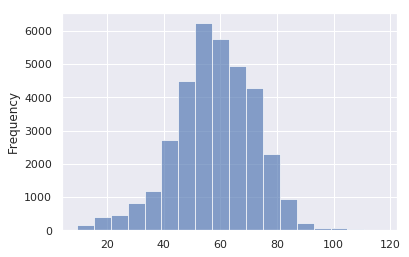

In [52]:
# Plot the histogram of the actual electricity price

ax = df_energy['price actual'].plot.hist(bins=18, alpha=0.65)

In the figure above, we can see that the actual energy price roughly follows a normal distribution and thus, could be standardized. However, we also have to make sure that the time series does not require any other kinds of transformations. More specifically, we will check whether the time series of energy price is stationary, after visualizing its decomposed component time-series. 

## <a id='ref13'>2.2. Decomposition and stationarity tests</a> 

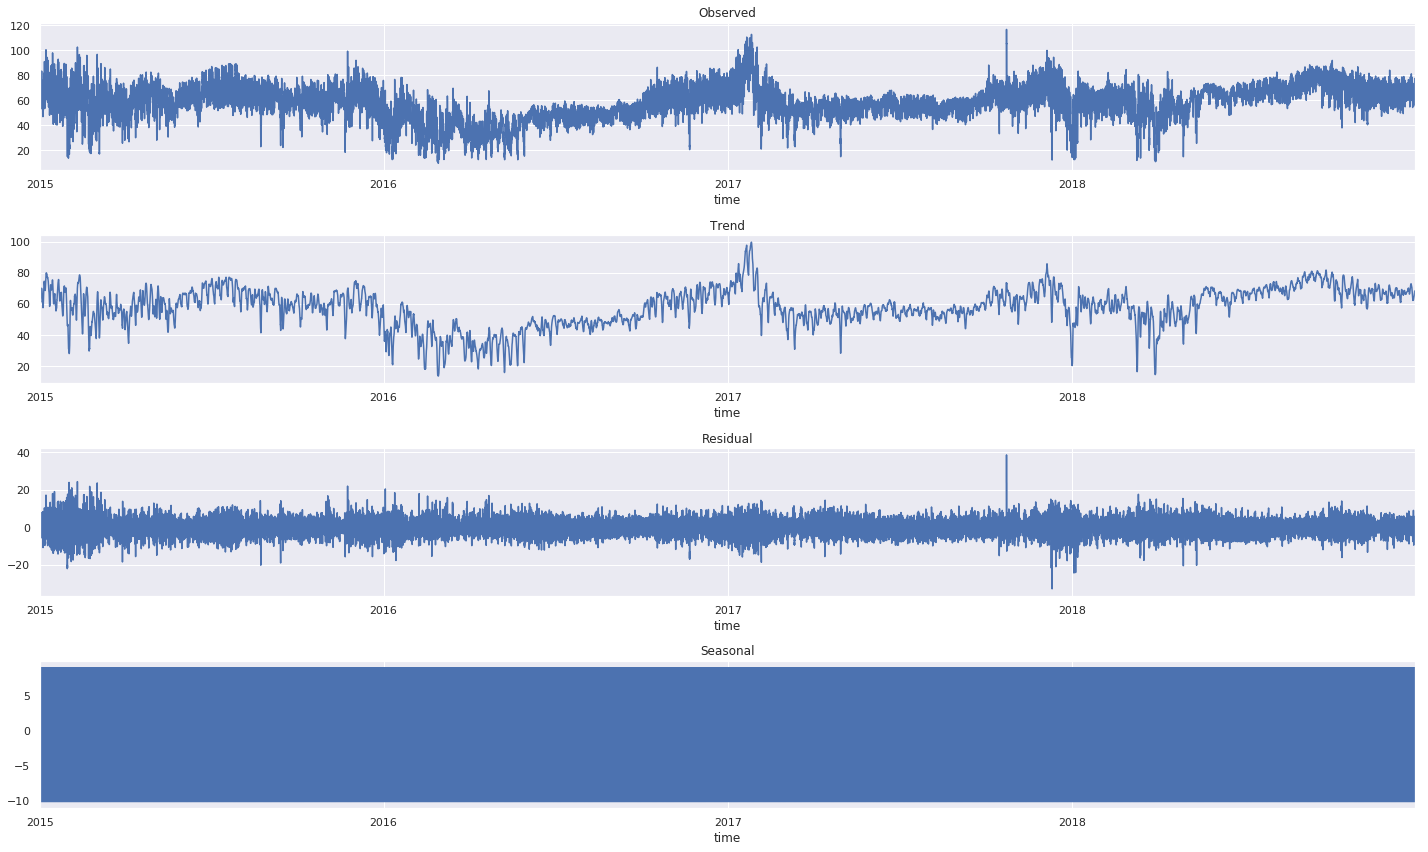

In [53]:
# Decompose the electricity price time series

res = sm.tsa.seasonal_decompose(df_energy['price actual'], model='additive')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))
res.observed.plot(ax=ax1, title='Observed')
res.trend.plot(ax=ax2, title='Trend')
res.resid.plot(ax=ax3, title='Residual')
res.seasonal.plot(ax=ax4, title='Seasonal')
plt.tight_layout()
plt.show()

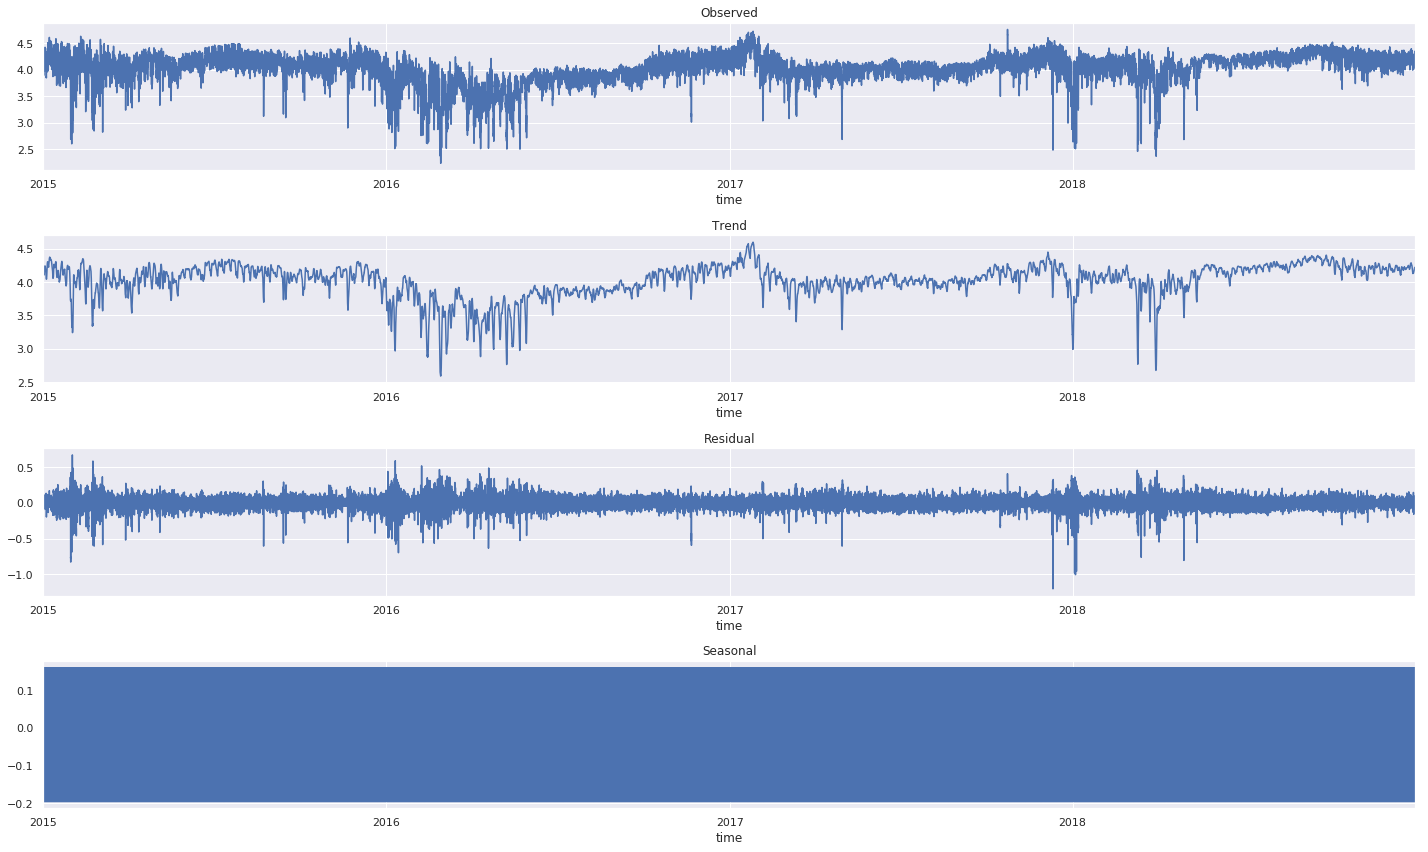

In [54]:
# Decompose the log electricity price time-series

res = sm.tsa.seasonal_decompose(np.log(df_energy['price actual']), model='additive')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))
res.observed.plot(ax=ax1, title='Observed')
res.trend.plot(ax=ax2, title='Trend')
res.resid.plot(ax=ax3, title='Residual')
res.seasonal.plot(ax=ax4, title='Seasonal')
plt.tight_layout()
plt.show()

The **Augmented Dickey-Fuller (ADF) test**, a type of unit root test, determines how strongly a time series is defined by a trend. Its hypotheses are the following:
- **Null Hypothesis** $H_{0}$: There is a unit root in the time series, i.e. the series is autocorrelated with (r=1), a time dependent structure and thus, is not stationary.
- **Alternate Hypothesis** $H_{1}$: The time series has no unit root and is either stationary or can be made stationary using differencing.

In [55]:
y = df_final['price actual']
adf_test = adfuller(y, regression='c')
print('ADF Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(adf_test[0], adf_test[1], adf_test[2]))
for key, value in adf_test[4].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

ADF Statistic: -9.147016
p-value: 0.000000
#Lags used: 50
Critical Value (1%): -3.430537
Critical Value (5%): -2.861623
Critical Value (10%): -2.566814


The ADF statistic (-9.147) is less than the critical value at 1% (-3.431) and thus, we can say that **we reject the null hypothesis $H_{0}$ with a significance level 1%**, meaning that there is not a root-unit in the time series and thus, that it is either stationary or could be made stationary with 1st order differencing (difference-stationary).

The **Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test**, follows the opposite logic from Augmented Dickey-Fuller test and checks for  stationarity. Its hypotheses are the following:
- **Null Hypothesis** $H_{0}$: The time series is level, i.e. it is stationary around a constant.
- **Alternate Hypothesis** $H_{1}$: There is a unit root in the time series and thus it not stationary.

In [56]:
kpss_test = kpss(y, regression='c', lags='legacy')
print('KPSS Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(kpss_test[0], kpss_test[1], kpss_test[2]))
for key, value in kpss_test[3].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

KPSS Statistic: 7.957007
p-value: 0.010000
#Lags used: 52
Critical Value (10%): 0.347000
Critical Value (5%): 0.463000
Critical Value (2.5%): 0.574000
Critical Value (1%): 0.739000


The KPSS statistic (7.957) is higher than the critical value at 1% (0.739) and thus, we can say that **we cannot reject the null hypothesis $H_{0}$ with a significance level 1%**, meaning that the time series is stationary or stationary around a constant.

Both tests concluded that the electricity price time series is stationary, while it is also true that deep neural networks can handle such properties in a more forgiving way compared to ARIMA models.

## <a id='ref14'>2.3. Autocorrelation, partial autocorrelation and cross-correlation</a> 

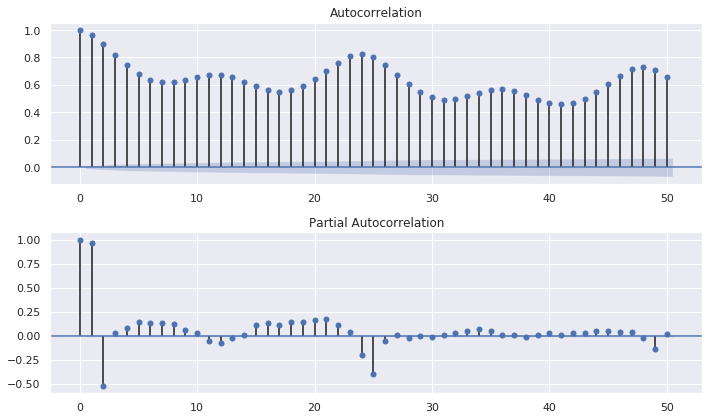

In [57]:
# Plot autocorrelation and partial autocorrelation plots

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(df_final['price actual'], lags=50, ax=ax1)
plot_pacf(df_final['price actual'], lags=50, ax=ax2)
plt.tight_layout()
plt.show()

The partial autocorrelation plot of the eletricity price time series shows that the direct relationship between an observation at a given hour (t) is strongest with the observations at t-1, t-2, t-24 and t-25 time-steps and diminishes afterwards. Thus, we are going to use the 25 previous values of each time series which will constitute a feature for our models. 

Nevertheless, it would quite definitely be more beneficial if we only chose to use specific past values (observations at certain time-lags) of a given feature, based on the cross-correlation between the electricity price and each one of the features in the dataset. For example, below we can see the cross-correlation between the electricity price and the total load. We see that there are many time-lags with a correlation which is close to zero and could be ommited. 

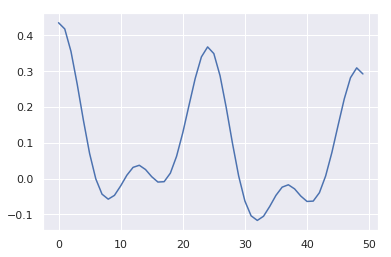

In [58]:
cross_corr = ccf(df_final['total load actual'], df_final['price actual'])
plt.plot(cross_corr[0:50])
plt.show()

For simplicity, we will just work with the correlations between the electricity price and the other features at each given hour.

In [59]:
# Find the correlations between the electricity price and the rest of the features

correlations = df_final.corr(method='pearson')
print(correlations['price actual'].sort_values(ascending=False).to_string())

price actual                                   1.000000
price day ahead                                0.732155
generation fossil hard coal                    0.465637
generation fossil gas                          0.461452
total load actual                              0.435253
generation fossil brown coal/lignite           0.363993
generation fossil oil                          0.285050
generation other renewable                     0.255551
pressure_Barcelona                             0.249177
pressure_Bilbao                                0.194063
generation waste                               0.168710
generation biomass                             0.142671
temp_min_Valencia                              0.133141
pressure_Valencia                              0.109812
temp_min_Barcelona                             0.103726
generation other                               0.099914
generation solar                               0.098529
temp_max_Madrid                                0

From the above, we can already see some very interesting correlations among the energy price that we want to predict and the rest of the features. For example, the total energy load and the amount of energy generated from sources related to fossil fuels, is positively correlated with the electricity price. In contrast, the wind speed in almost every city and the amount of storage energy cosumed through hydroelectric pumping is negatively correlated with the energy price. We will go ahead and drop the 'snow_3h_Barcelona' and 'snow_3h_Seville' which give NaNs in their correlations with the electricity actual price.

In [60]:
df_final = df_final.drop(['snow_3h_Barcelona', 'snow_3h_Seville'], axis=1)

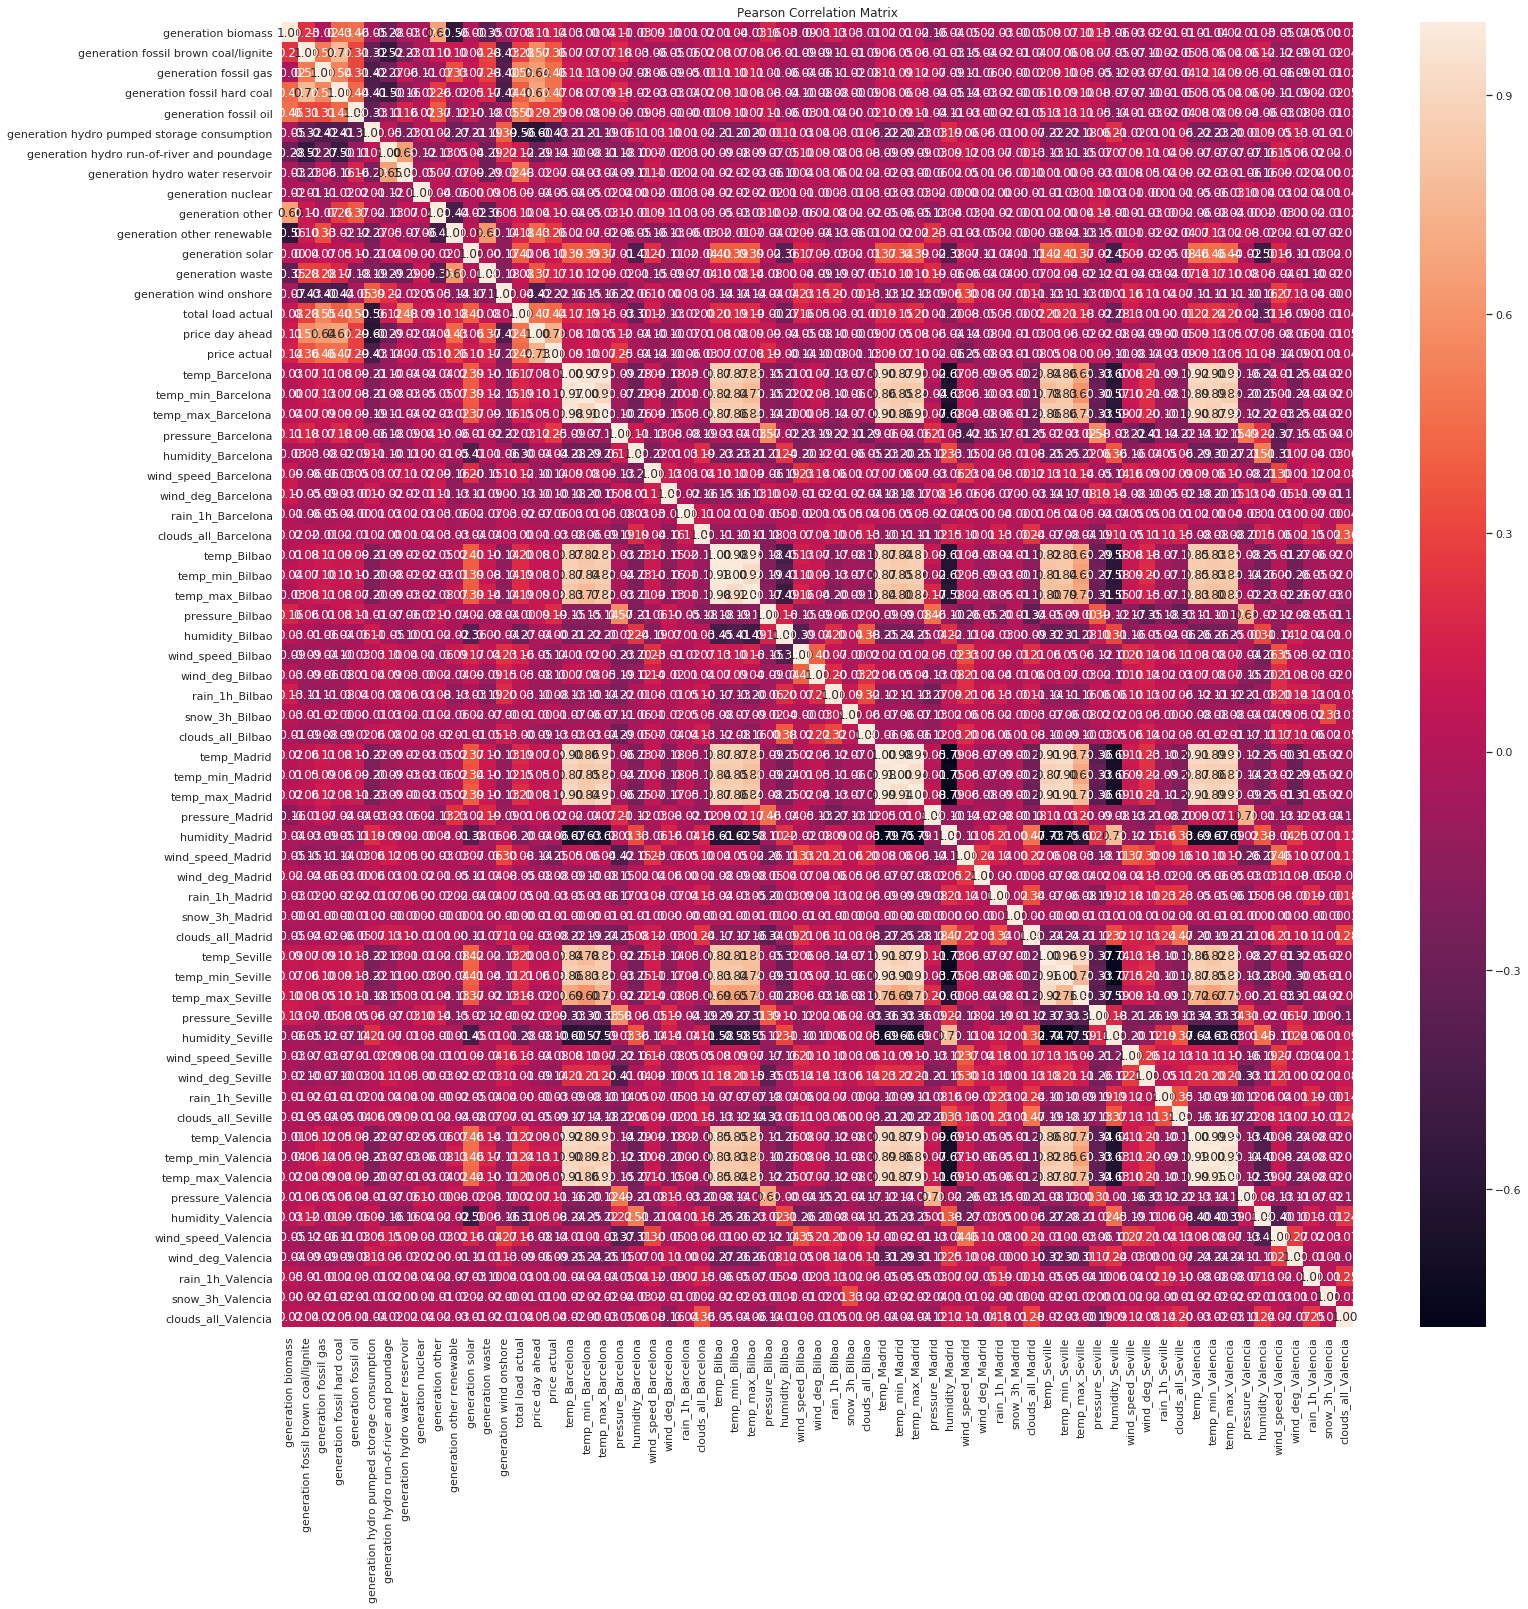

In [61]:
# Plot Pearson correlation matrix

correlations = df_final.corr(method='pearson')
fig = plt.figure(figsize=(24, 24))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Pearson Correlation Matrix')
plt.show()

While we cannot make a lot out of the above correlation matrix, we can observe that there quite a lot of features that are highly correlated with each other.

In [62]:
highly_correlated = abs(correlations[correlations > 0.75])
print(highly_correlated[highly_correlated < 1.0].stack().to_string())

generation fossil brown coal/lignite  generation fossil hard coal             0.768831
generation fossil hard coal           generation fossil brown coal/lignite    0.768831
temp_Barcelona                        temp_min_Barcelona                      0.970264
                                      temp_max_Barcelona                      0.976904
                                      temp_Bilbao                             0.866727
                                      temp_min_Bilbao                         0.867970
                                      temp_max_Bilbao                         0.828347
                                      temp_Madrid                             0.903996
                                      temp_min_Madrid                         0.874548
                                      temp_max_Madrid                         0.899010
                                      temp_Seville                            0.841910
                                      temp_

What we can observe, is that apart from the amount of energy generated by fossil brown coal/lignit and hard coal, the most correlated features have to do with the temperatures among the different cities, as well the "secondary" information we have about the temperature of each individual city (i.e. the minimunm and maximum temperature).

# <a id='ref15'>3. Feature Engineering</a>

## <a id='ref16'>3.1. Feature generation</a> 

The first features that we will generate for a given hour will just be that particular hour, the day and the month in which it falls into.

In [63]:
# Generate 'hour', 'weekday' and 'month' features

for i in range(len(df_final)):
    position = df_final.index[i]
    hour = position.hour
    weekday = position.weekday()
    month = position.month
    df_final.loc[position, 'hour'] = hour
    df_final.loc[position, 'weekday'] = weekday
    df_final.loc[position, 'month'] = month

A very useful feature that we will generate, has to do with the business hours, i.e. whether businesses are open or not in a given hour. However, there is a certain peculiarity in Spain as the 9AM-5PM working day is not generally followed by all types of businesses, due to a lunch break (known as "siesta") in between. The most usual business hours are from Monday-Saturday, from 9:30AM-1:30PM and then again from 4:30PM-8PM.

Therefore, the value of the 'business hour' will be equal to '2' if the given hour is within the business hours, equal to '1' if the given hour is within the "siesta" in between and equal to '0' for all other given hours.

In [64]:
# Generate 'business hour' feature

for i in range(len(df_final)):
    position = df_final.index[i]
    hour = position.hour
    if ((hour > 8 and hour < 14) or (hour > 16 and hour < 21)):
        df_final.loc[position, 'business hour'] = 2
    elif (hour >= 14 and hour <= 16):
        df_final.loc[position, 'business hour'] = 1
    else:
        df_final.loc[position, 'business hour'] = 0

However, we have generated the 'business hour' feature in such a way which also includes weekends, on which fewer -or different types of- businesses are open. Thus, it is useful to also generate another feature, 'weekend', which will distuingish weekdays and weekends, as well as make a distinction between Saturdays and Sundays.

In particular, for a particular given hour, the value of 'weekend' will be equal to '0', if the hours is in a weekday, equal to '1' if the hour is in a Saturday and equal to '2' if the hour is in a Sunday.

In [65]:
# Generate 'weekend' feature

for i in range(len(df_final)):
    position = df_final.index[i]
    weekday = position.weekday()
    if (weekday == 6):
        df_final.loc[position, 'weekday'] = 2
    elif (weekday == 5):
        df_final.loc[position, 'weekday'] = 1
    else:
        df_final.loc[position, 'weekday'] = 0

In order to reduce the dimensionality and potentially acquire a new kind of information, for every given hour, we will subtract the minimum temperature ('temp_min') from the maximum temperature ('temp_max') for each city and we will name that feature 'temp_range_{name of city}'.

In [66]:
# Generate 'temp_range' for each city

cities = ['Barcelona', 'Bilbao', 'Madrid', 'Seville', 'Valencia']

for i in range(len(df_final)):
    position = df_final.index[i]
    for city in cities:
        temp_max = df_final.loc[position, 'temp_max_{}'.format(city)]
        temp_min = df_final.loc[position, 'temp_min_{}'.format(city)]
        df_final.loc[position, 'temp_range_{}'.format(city)] = abs(temp_max - temp_min)

After seeing that there is a high correlation among the temperatures of the different cities, we will also try creating a weighted temperature features by taking into account each city's population [[7]](#ref40).

- Madrid: 6,155,116
- Barcelona: 5,179,243
- Valencia: 1,645,342
- Seville: 1,305,342
- Bilbao: 987,000

In [67]:
# Calculate the weight of every city

total_pop = 6155116 + 5179243 + 1645342 + 1305342 + 987000

weight_Madrid = 6155116 / total_pop
weight_Barcelona = 5179243 / total_pop
weight_Valencia = 1645342 / total_pop
weight_Seville = 1305342 / total_pop
weight_Bilbao = 987000 / total_pop

In [68]:
cities_weights = {'Madrid': weight_Madrid, 
                  'Barcelona': weight_Barcelona,
                  'Valencia': weight_Valencia,
                  'Seville': weight_Seville,
                  'Bilbao': weight_Bilbao}

In [69]:
# Generate 'temp_weighted' feature

for i in range(len(df_final)):
    position = df_final.index[i]
    temp_weighted = 0
    for city in cities:
        temp = df_final.loc[position, 'temp_{}'.format(city)]
        temp_weighted += temp * cities_weights.get('{}'.format(city))
    df_final.loc[position, 'temp_weighted'] = temp_weighted

We will also generate a new feature which aggregates both energy sources which are related to coal and are highly correlated (0.7688).

In [70]:
df_final['generation coal all'] = df_final['generation fossil hard coal'] + df_final['generation fossil brown coal/lignite']

## <a id='ref17'>3.2. Feature selection</a> 

In [71]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i + target_size])

    return np.array(data), np.array(labels)

In [72]:
train_end_idx = 27048
cv_end_idx = 31056
test_end_idx = 35064

In [73]:
X = df_final[df_final.columns.drop('price actual')].values
y = df_final['price actual'].values

y = y.reshape(-1, 1)

In [74]:
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

In [75]:
scaler_X.fit(X[:train_end_idx])
scaler_y.fit(y[:train_end_idx])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [76]:
X_norm = scaler_X.transform(X)
y_norm = scaler_y.transform(y)

In [77]:
pca = PCA()
X_pca = pca.fit(X_norm[:train_end_idx])

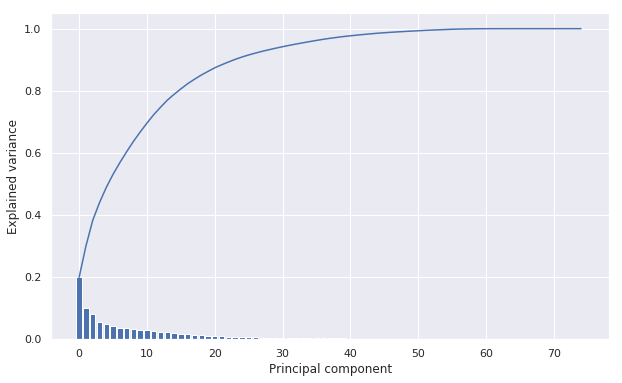

In [78]:
num_components = len(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.bar(np.arange(num_components), pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Principal component')
plt.ylabel('Explained variance')
plt.show()

In [79]:
pca = PCA(n_components=0.80)
pca.fit(X_norm[:train_end_idx])
X_pca = pca.transform(X_norm)

In [80]:
X_pca.shape

(35064, 16)

In [81]:
dataset_norm = np.concatenate((X_pca, y_norm), axis=1)

past_history = 24
future_target = 0

In [82]:
X_train, y_train = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                     0, train_end_idx, past_history, 
                                     future_target, step=1, single_step=True)

In [83]:
X_val, y_val = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                 train_end_idx, cv_end_idx, past_history, 
                                 future_target, step=1, single_step=True)

In [84]:
X_test, y_test = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                   cv_end_idx, test_end_idx, past_history, 
                                   future_target, step=1, single_step=True)

In [85]:
batch_size = 32
buffer_size = 1000

In [86]:
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.cache().shuffle(buffer_size).batch(batch_size).prefetch(1)

validation = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation = validation.batch(batch_size).prefetch(1)

In [87]:
# Define some common parameters

input_shape = X_train.shape[-2:]
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

In [88]:
y_test = y_test.reshape(-1, 1)
y_test_inv = scaler_y.inverse_transform(y_test)

# <a id='ref18'>4. Electricity Price Forecasting</a> 

In [89]:
def plot_model_rmse_and_loss(history):
    
    # Evaluate train and validation accuracies and losses
    
    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Visualize epochs vs. train and validation accuracies and losses
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')
    
    plt.show()

## <a id='ref19'>4.1. Naive Forecast</a> 

## <a id='ref20'>4.2. XGBoost</a> 

In [90]:
X_train_xgb = X_train.reshape(-1, X_train.shape[1] * X_train.shape[2])
X_val_xgb = X_val.reshape(-1, X_val.shape[1] * X_val.shape[2])
X_test_xgb = X_test.reshape(-1, X_test.shape[1] * X_test.shape[2])

In [91]:
param = {'eta': 0.03, 'max_depth': 180, 
         'subsample': 1.0, 'colsample_bytree': 0.95, 
         'alpha': 0.1, 'lambda': 0.15, 'gamma': 0.1,
         'objective': 'reg:linear', 'eval_metric': 'rmse', 
         'silent': 1, 'min_child_weight': 0.1, 'n_jobs': -1}

dtrain = xgb.DMatrix(X_train_xgb, y_train)
dval = xgb.DMatrix(X_val_xgb, y_val)
dtest = xgb.DMatrix(X_test_xgb, y_test)
eval_list = [(dtrain, 'train'), (dval, 'eval')]

xgb_model = xgb.train(param, dtrain, 180, eval_list, early_stopping_rounds=3)

[0]	train-rmse:0.144136	eval-rmse:0.117006
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 3 rounds.
[1]	train-rmse:0.140028	eval-rmse:0.11371
[2]	train-rmse:0.136049	eval-rmse:0.110503
[3]	train-rmse:0.132193	eval-rmse:0.107422
[4]	train-rmse:0.128457	eval-rmse:0.104417
[5]	train-rmse:0.124846	eval-rmse:0.101527
[6]	train-rmse:0.12134	eval-rmse:0.098681
[7]	train-rmse:0.117944	eval-rmse:0.095938
[8]	train-rmse:0.11466	eval-rmse:0.093297
[9]	train-rmse:0.111477	eval-rmse:0.090772
[10]	train-rmse:0.108396	eval-rmse:0.088281
[11]	train-rmse:0.105411	eval-rmse:0.085877
[12]	train-rmse:0.10252	eval-rmse:0.083553
[13]	train-rmse:0.099718	eval-rmse:0.081316
[14]	train-rmse:0.097014	eval-rmse:0.079143
[15]	train-rmse:0.094523	eval-rmse:0.077208
[16]	train-rmse:0.091977	eval-rmse:0.075181
[17]	train-rmse:0.089517	eval-rmse:0.073222
[18]	train-rmse:0.08714	eval-rmse:0.071311
[19]	train-rmse:0.084834	eval-rmse:0.

In [92]:
forecast = xgb_model.predict(dtest)
xgb_forecast = forecast.reshape(-1, 1)

xgb_forecast_inv = scaler_y.inverse_transform(xgb_forecast)

rmse_xgb = sqrt(mean_squared_error(y_test_inv, xgb_forecast_inv))
print('RMSE of hour-ahead electricity price XGBoost forecast: {}'
      .format(round(rmse_xgb, 3)))

RMSE of hour-ahead electricity price XGBoost forecast: 2.214


## <a id='ref21'>4.3. LSTM</a> 

In [93]:
tf.keras.backend.clear_session()

multivariate_lstm = tf.keras.models.Sequential([
    LSTM(100, input_shape=input_shape, 
         return_sequences=True),
    Flatten(),
    Dense(200, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_lstm.h5', monitor=('val_loss'), save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=6e-3, amsgrad=True)

multivariate_lstm.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [94]:
history = multivariate_lstm.fit(train, epochs=120,
                                validation_data=validation,
                                callbacks=[early_stopping, 
                                           model_checkpoint])

Epoch 1/120
845/845 [==============================] - 10s 12ms/step - loss: 0.0638 - root_mean_squared_error: 0.2526 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 2/120
845/845 [==============================] - 5s 6ms/step - loss: 0.0037 - root_mean_squared_error: 0.0610 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0580
Epoch 3/120
845/845 [==============================] - 4s 5ms/step - loss: 0.0029 - root_mean_squared_error: 0.0536 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0572
Epoch 4/120
845/845 [==============================] - 5s 5ms/step - loss: 0.0023 - root_mean_squared_error: 0.0484 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0484
Epoch 5/120
845/845 [==============================] - 5s 6ms/step - loss: 0.0020 - root_mean_squared_error: 0.0445 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0496
Epoch 6/120
845/845 [==============================] - 5s 5ms/step - loss: 0.0018 - root_mean_squared_error: 0.0424 - val_los

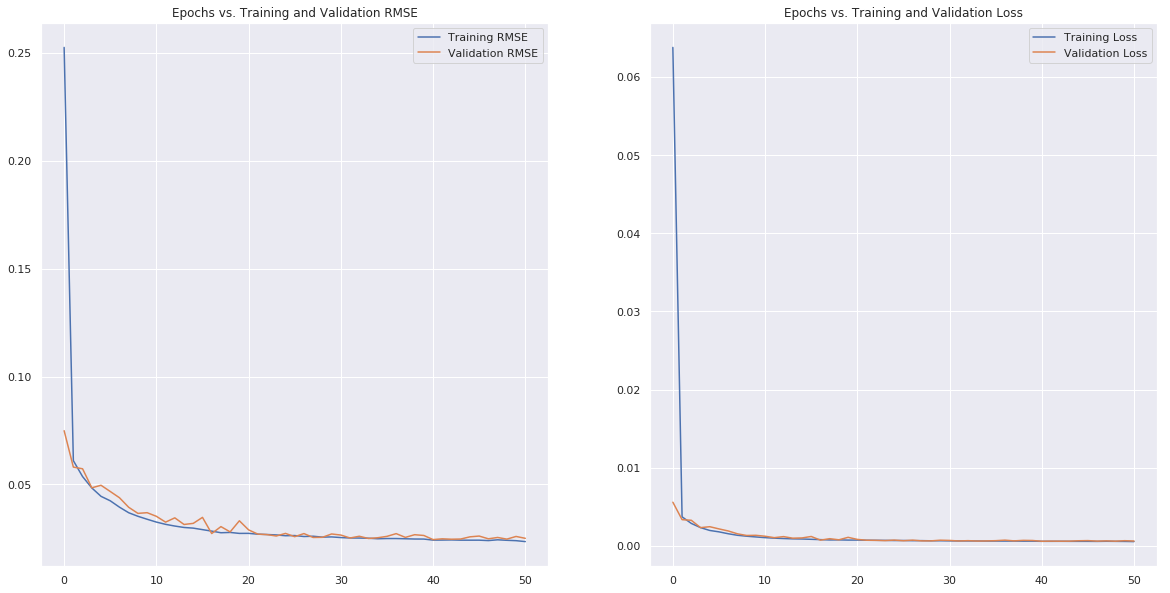

In [95]:
plot_model_rmse_and_loss(history)

In [96]:
multivariate_lstm = tf.keras.models.load_model('multivariate_lstm.h5')

forecast = multivariate_lstm.predict(X_test)
lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_lstm = sqrt(mean_squared_error(y_test_inv,
                                    lstm_forecast))
print('RMSE of hour-ahead electricity price LSTM forecast: {}'
      .format(round(rmse_lstm, 3)))

RMSE of hour-ahead electricity price LSTM forecast: 2.265


## <a id='ref22'>4.4. Stacked LSTM</a> 

In [97]:
tf.keras.backend.clear_session()

multivariate_stacked_lstm = tf.keras.models.Sequential([
    LSTM(250, input_shape=input_shape, 
         return_sequences=True),
    LSTM(150, return_sequences=True),
    Flatten(),
    Dense(150, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_stacked_lstm.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=3e-3, amsgrad=True)

multivariate_stacked_lstm.compile(loss=loss,
                                  optimizer=optimizer,
                                  metrics=metric)

In [98]:
history = multivariate_stacked_lstm.fit(train, epochs=120,
                                validation_data=validation,
                                callbacks=[early_stopping, 
                                           model_checkpoint])

Epoch 1/120
845/845 [==============================] - 11s 13ms/step - loss: 0.0250 - root_mean_squared_error: 0.1581 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 2/120
845/845 [==============================] - 7s 8ms/step - loss: 0.0040 - root_mean_squared_error: 0.0629 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0756
Epoch 3/120
845/845 [==============================] - 7s 8ms/step - loss: 0.0031 - root_mean_squared_error: 0.0552 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0606
Epoch 4/120
845/845 [==============================] - 7s 8ms/step - loss: 0.0025 - root_mean_squared_error: 0.0500 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0520
Epoch 5/120
845/845 [==============================] - 6s 8ms/step - loss: 0.0022 - root_mean_squared_error: 0.0464 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0475
Epoch 6/120
845/845 [==============================] - 7s 8ms/step - loss: 0.0019 - root_mean_squared_error: 0.0433 - val_los

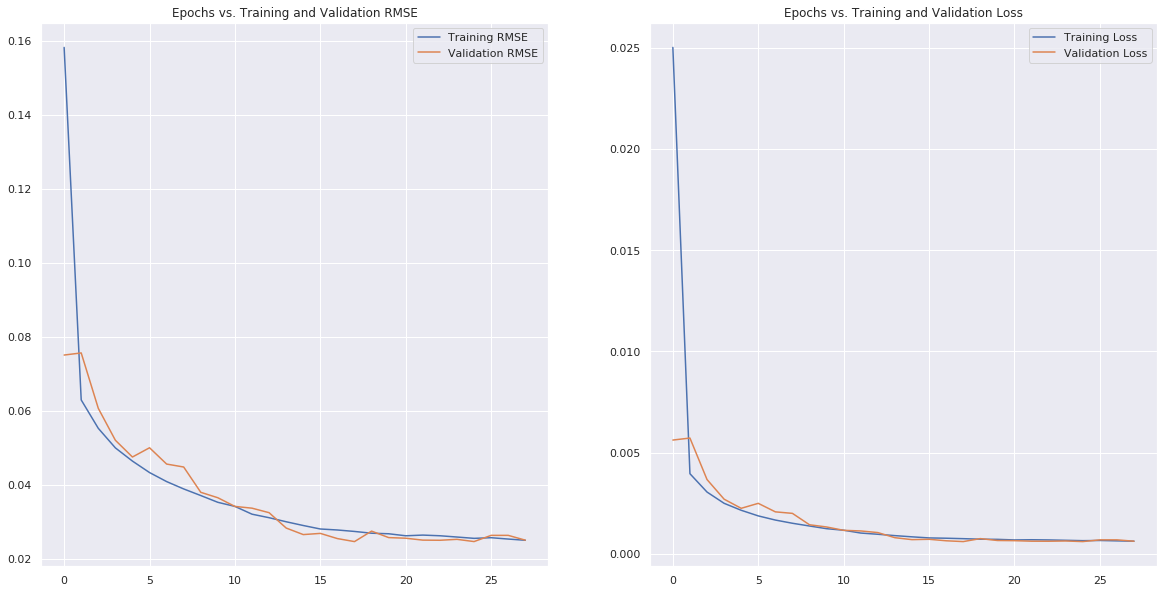

In [99]:
plot_model_rmse_and_loss(history)

In [100]:
multivariate_stacked_lstm = tf.keras.models.load_model('multivariate_stacked_lstm.h5')

forecast = multivariate_stacked_lstm.predict(X_test)
multivariate_stacked_lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_stacked_lstm = sqrt(mean_squared_error(y_test_inv, 
                                                 multivariate_stacked_lstm_forecast))
print('RMSE of hour-ahead electricity price multivariate Stacked LSTM forecast: {}'
      .format(round(rmse_mult_stacked_lstm, 3)))


RMSE of hour-ahead electricity price multivariate Stacked LSTM forecast: 2.348


## <a id='ref23'>4.5. CNN</a> 

In [101]:
tf.keras.backend.clear_session()

multivariate_cnn = tf.keras.models.Sequential([
    Conv1D(filters=48, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape),
    Flatten(),
    Dense(48, activation='relu'),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_cnn.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=6e-3, amsgrad=True)

multivariate_cnn.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [102]:
history = multivariate_cnn.fit(train, epochs=120,
                               validation_data=validation,
                               callbacks=[early_stopping, 
                                          model_checkpoint])

Epoch 1/120
845/845 [==============================] - 5s 5ms/step - loss: 0.0259 - root_mean_squared_error: 0.1610 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 2/120
845/845 [==============================] - 3s 3ms/step - loss: 0.0023 - root_mean_squared_error: 0.0480 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0510
Epoch 3/120
845/845 [==============================] - 3s 4ms/step - loss: 0.0014 - root_mean_squared_error: 0.0376 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0412
Epoch 4/120
845/845 [==============================] - 3s 4ms/step - loss: 0.0011 - root_mean_squared_error: 0.0325 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0340
Epoch 5/120
845/845 [==============================] - 3s 4ms/step - loss: 8.8127e-04 - root_mean_squared_error: 0.0297 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0328
Epoch 6/120
845/845 [==============================] - 3s 4ms/step - loss: 7.4647e-04 - root_mean_squared_error: 0.0273 - v

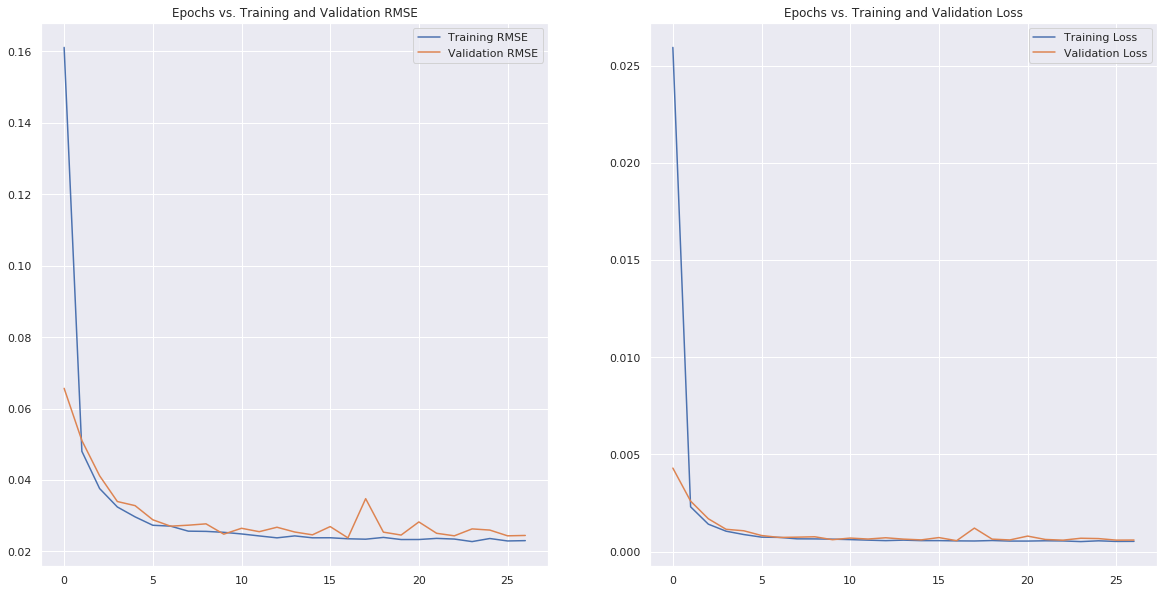

In [103]:
plot_model_rmse_and_loss(history)

In [104]:
multivariate_cnn = tf.keras.models.load_model('multivariate_cnn.h5')

forecast = multivariate_cnn.predict(X_test)
multivariate_cnn_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_cnn = sqrt(mean_squared_error(y_test_inv,
                                        multivariate_cnn_forecast))
print('RMSE of hour-ahead electricity price multivariate CNN forecast: {}'
      .format(round(rmse_mult_cnn, 3)))

RMSE of hour-ahead electricity price multivariate CNN forecast: 2.324


## <a id='ref24'>4.6. CNN-LSTM</a> 

In [105]:
tf.keras.backend.clear_session()

multivariate_cnn_lstm = tf.keras.models.Sequential([
    Conv1D(filters=100, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape),
    LSTM(100, return_sequences=True),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_cnn_lstm.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=4e-3, amsgrad=True)

multivariate_cnn_lstm.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)


In [106]:
history = multivariate_cnn_lstm.fit(train, epochs=120,
                                    validation_data=validation,
                                    callbacks=[early_stopping, 
                                               model_checkpoint])

Epoch 1/120
845/845 [==============================] - 8s 10ms/step - loss: 0.0157 - root_mean_squared_error: 0.1255 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 2/120
845/845 [==============================] - 5s 6ms/step - loss: 0.0020 - root_mean_squared_error: 0.0452 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0627
Epoch 3/120
845/845 [==============================] - 5s 6ms/step - loss: 0.0016 - root_mean_squared_error: 0.0399 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0464
Epoch 4/120
845/845 [==============================] - 5s 6ms/step - loss: 0.0013 - root_mean_squared_error: 0.0364 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0444
Epoch 5/120
845/845 [==============================] - 6s 7ms/step - loss: 0.0010 - root_mean_squared_error: 0.0321 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0437
Epoch 6/120
845/845 [==============================] - 5s 6ms/step - loss: 8.7611e-04 - root_mean_squared_error: 0.0296 - val_

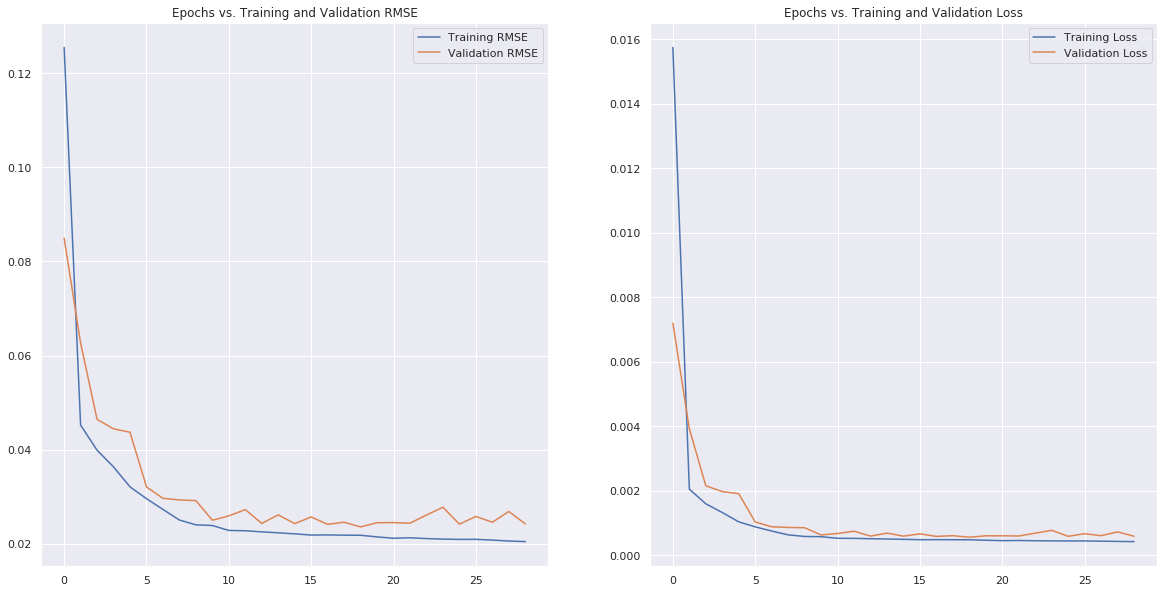

In [107]:
plot_model_rmse_and_loss(history)

In [108]:
multivariate_cnn_lstm = tf.keras.models.load_model('multivariate_cnn_lstm.h5')

forecast = multivariate_cnn_lstm.predict(X_test)
multivariate_cnn_lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_cnn_lstm = sqrt(mean_squared_error(y_test_inv, 
                                             multivariate_cnn_lstm_forecast))
print('RMSE of hour-ahead electricity price multivariate CNN-`LSTM forecast: {}'
      .format(round(rmse_mult_cnn_lstm, 3)))

RMSE of hour-ahead electricity price multivariate CNN-`LSTM forecast: 2.309


In [109]:
X_test.shape

(3984, 24, 17)

## <a id='ref25'>4.7. Time Distributed MLP</a> 

In [110]:
tf.keras.backend.clear_session()

multivariate_mlp = tf.keras.models.Sequential([
    TimeDistributed(Dense(200, activation='relu'),
                    input_shape=input_shape),
    TimeDistributed(Dense(150, activation='relu')),
    TimeDistributed(Dense(100, activation='relu')),
    TimeDistributed(Dense(50, activation='relu')),
    Flatten(),
    Dense(150, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_mlp.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=2e-3, amsgrad=True)

multivariate_mlp.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [111]:
history = multivariate_mlp.fit(train, epochs=120,
                               validation_data=validation,
                               callbacks=[early_stopping, 
                                          model_checkpoint])

Epoch 1/120
845/845 [==============================] - 5s 6ms/step - loss: 0.0054 - root_mean_squared_error: 0.0733 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 2/120
845/845 [==============================] - 4s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0416 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0427
Epoch 3/120
845/845 [==============================] - 3s 4ms/step - loss: 0.0012 - root_mean_squared_error: 0.0353 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0348
Epoch 4/120
845/845 [==============================] - 3s 4ms/step - loss: 0.0010 - root_mean_squared_error: 0.0320 - val_loss: 8.1535e-04 - val_root_mean_squared_error: 0.0286
Epoch 5/120
845/845 [==============================] - 3s 4ms/step - loss: 9.6047e-04 - root_mean_squared_error: 0.0310 - val_loss: 7.6166e-04 - val_root_mean_squared_error: 0.0276
Epoch 6/120
845/845 [==============================] - 3s 4ms/step - loss: 8.2742e-04 - root_mean_squared_error: 0.

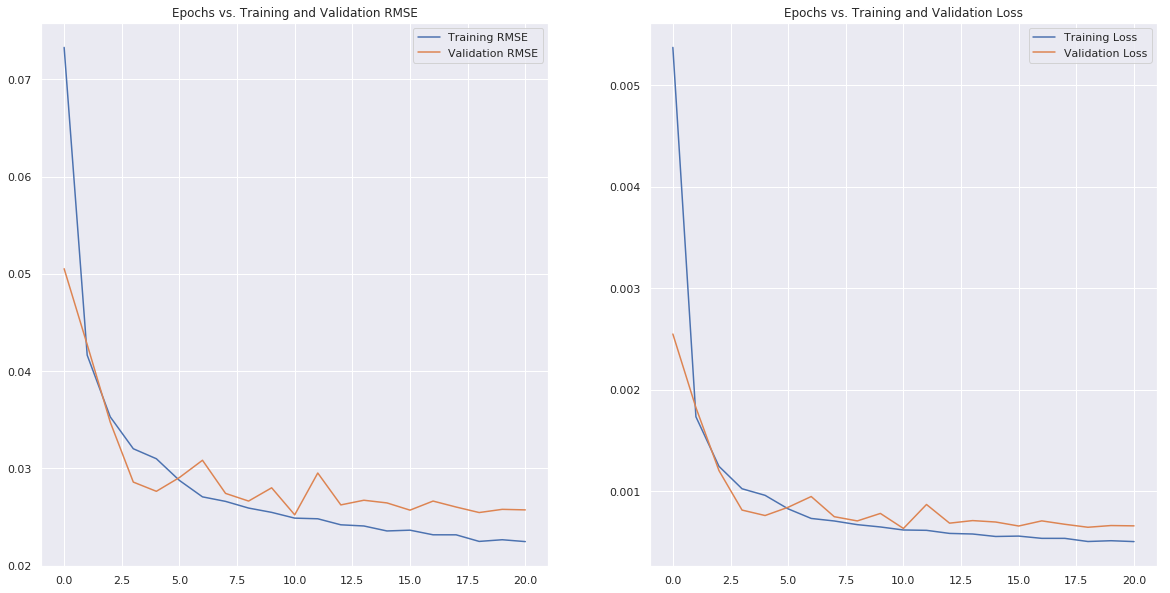

In [112]:
plot_model_rmse_and_loss(history)

In [113]:
multivariate_mlp = tf.keras.models.load_model('multivariate_mlp.h5')

forecast = multivariate_mlp.predict(X_test)
multivariate_mlp_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_mlp = sqrt(mean_squared_error(y_test_inv,
                                        multivariate_mlp_forecast))
print('RMSE of hour-ahead electricity price multivariate MLP forecast: {}'
      .format(round(rmse_mult_mlp, 3)))

RMSE of hour-ahead electricity price multivariate MLP forecast: 2.331


## <a id='ref26'>4.8. Encoder-Decoder</a> 

In [114]:
tf.keras.backend.clear_session()

encoder_decoder = tf.keras.models.Sequential([
    LSTM(50, activation='relu', input_shape=input_shape),
    RepeatVector(past_history),
    LSTM(50, activation='relu', return_sequences=True),
    TimeDistributed(Dense(50, activation='relu')),
    Flatten(),
    Dense(25, activation='relu'),
    Dense(1)
])



model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'encoder_decoder.h5', save_best_only=True)

optimizer = tf.keras.optimizers.Adam(lr=1e-3, amsgrad=True)

encoder_decoder.compile(loss=loss,
                    optimizer=optimizer,
                    metrics=metric)

In [115]:
history = encoder_decoder.fit(train, epochs=50,
                              validation_data=validation,
                              callbacks=[early_stopping, 
                                         model_checkpoint])

Epoch 1/50
845/845 [==============================] - 47s 56ms/step - loss: 0.0047 - root_mean_squared_error: 0.0682 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 2/50
845/845 [==============================] - 44s 52ms/step - loss: 0.0015 - root_mean_squared_error: 0.0393 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0455
Epoch 3/50
845/845 [==============================] - 44s 52ms/step - loss: 0.0011 - root_mean_squared_error: 0.0328 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0332
Epoch 4/50
845/845 [==============================] - 43s 51ms/step - loss: 9.2001e-04 - root_mean_squared_error: 0.0303 - val_loss: 9.3069e-04 - val_root_mean_squared_error: 0.0306
Epoch 5/50
845/845 [==============================] - 44s 53ms/step - loss: 7.7430e-04 - root_mean_squared_error: 0.0278 - val_loss: 8.3191e-04 - val_root_mean_squared_error: 0.0289
Epoch 6/50
845/845 [==============================] - 43s 51ms/step - loss: 7.2523e-04 - root_mean_squared

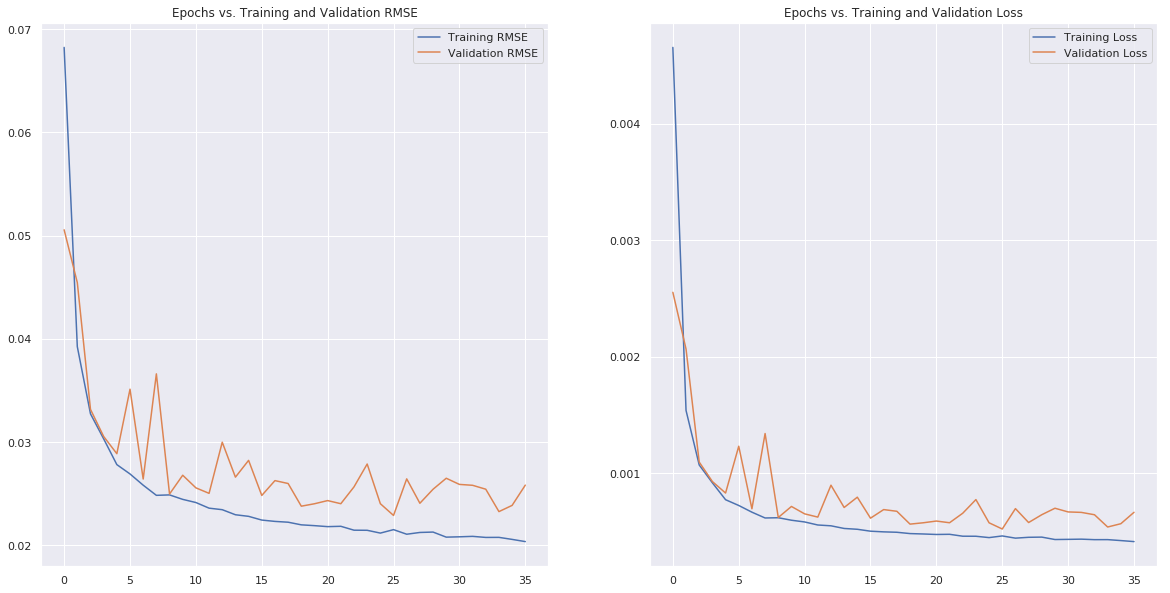

In [116]:
plot_model_rmse_and_loss(history)

In [117]:
encoder_decoder = tf.keras.models.load_model('encoder_decoder.h5')

forecast = encoder_decoder.predict(X_test)
encoder_decoder_forecast = scaler_y.inverse_transform(forecast)

rmse_encoder_decoder = sqrt(mean_squared_error(y_test_inv, 
                                               encoder_decoder_forecast))
print('RMSE of hour-ahead electricity price Encoder-Decoder forecast: {}'
      .format(round(rmse_encoder_decoder, 3)))

RMSE of hour-ahead electricity price Encoder-Decoder forecast: 2.296
